In [68]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from clust_huge_amp import *
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

def load_model_essentials(base_path='/Users/sarahurbut/Dropbox/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading components...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8667/2682547328.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/va

Loaded all components successfully!


In [69]:

# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, start_index=0, end_index=10000)

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Initialize model with subsetted data

del Y

In [70]:
# When initializing the model:
original_G = G_100k # Store the original G - proper tensor copy

# Now in your batch run, load and verify:
initial_psi = torch.load('/Users/sarahurbut/Dropbox/data_for_running/initial_psi_400k.pt')
initial_clusters = torch.load('/Users/sarahurbut/Dropbox/data_for_running/initial_clusters_400k.pt')

original_cluster_sizes = {}
unique, counts = np.unique(initial_clusters, return_counts=True)
for k, count in zip(unique, counts):
    original_cluster_sizes[k] = count
print("\nOriginal cluster sizes:")
for k, count in original_cluster_sizes.items():
    print(f"Cluster {k}: {count} diseases")


# Load references (signatures only, no healthy)
refs = torch.load('/Users/sarahurbut/Dropbox/data_for_running/reference_trajectories.pt')
signature_refs = refs['signature_refs']
# When initializing the model:





Original cluster sizes:
Cluster 0: 16 diseases
Cluster 1: 21 diseases
Cluster 2: 15 diseases
Cluster 3: 82 diseases
Cluster 4: 5 diseases
Cluster 5: 7 diseases
Cluster 6: 8 diseases
Cluster 7: 22 diseases
Cluster 8: 28 diseases
Cluster 9: 12 diseases
Cluster 10: 11 diseases
Cluster 11: 8 diseases
Cluster 12: 7 diseases
Cluster 13: 13 diseases
Cluster 14: 10 diseases
Cluster 15: 5 diseases
Cluster 16: 29 diseases
Cluster 17: 17 diseases
Cluster 18: 9 diseases
Cluster 19: 23 diseases


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8667/2949129839.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/Dr

In [71]:

torch.manual_seed(7)
np.random.seed(4)
# Create model without healthy reference
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0], 
    D=Y_100k.shape[1], 
    T=Y_100k.shape[2], 
    K=20,
    P=G_100k.shape[1],
    init_sd_scaler=1e-1,
    G=G_100k, 
    Y=Y_100k,
    genetic_scale=1,
    W=0.0001,
    R=0,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,  # Only pass signature refs
    healthy_reference=True,  # Explicitly set to None
    disease_names=essentials['disease_names']
)

torch.manual_seed(0)
np.random.seed(0)
# Initialize with psi and clusters
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters
# Verify clusters match
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_scaled, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 14
Base value (first 5): tensor([-18.4207, -18.4207, -17.3858, -16.3508, -16.3508])
Base value centered (first 5): tensor([-0.5458, -0.5458,  0.4891,  1.5240,  1.5240])
Base value centered mean: 3.23352810482902e-06
Gamma init for k=0 (first 5): tensor([ 0.0013,  0.0101,  0.0173,  0.0224, -0.0156])

Calculating gamma for k=1:
Number of diseases in cluster: 7
Base value (first 5): tensor([-18.4207, -18.4207, -18.4207, -18.4207, -18.4207])
Base value centered

In [72]:
initial_psi=model.psi
checkpoint=torch.load('/Users/sarahurbut/Dropbox/resultshighamp/results/output_0_10000/model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

# If you're doing inference, set to eval mode
model.eval()

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_8667/1544438175.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint=torch.load('/Users/sarahurbut/Dropb

AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest()

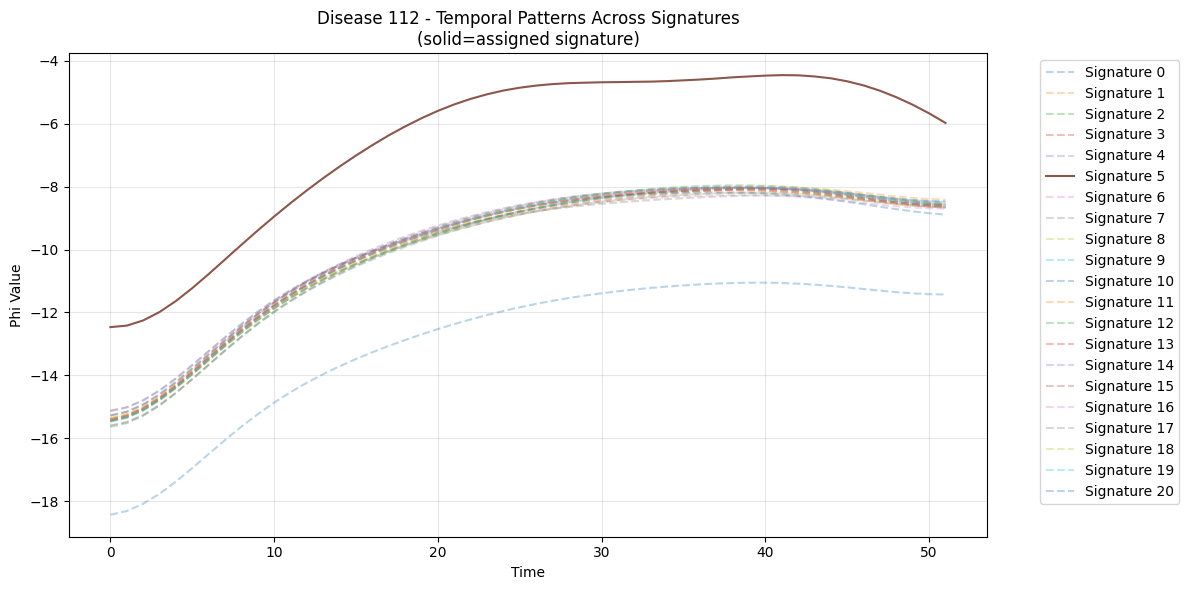


Psi values for disease 112:
Signature 0: -2.148
Signature 1: -2.055
Signature 2: -2.025
Signature 3: -2.243
Signature 4: -1.915
Signature 5: -1.085
Signature 6: -2.068
Signature 7: -2.066
Signature 8: -2.036
Signature 9: -2.165
Signature 10: -2.253
Signature 11: -2.050
Signature 12: -2.063
Signature 13: -1.999
Signature 14: -1.948
Signature 15: -1.935
Signature 16: -2.340
Signature 17: -2.151
Signature 18: -1.985
Signature 19: -2.077
Signature 20: -4.974


In [20]:

def plot_disease_signature_patterns(model, disease_idx=112):
    plt.figure(figsize=(12, 6))
    time_points = np.arange(model.T)
    
    # Get phi values for this disease across all signatures
    phi_disease = model.phi[:, disease_idx].detach()  # [K, T]
    psi_disease = model.psi[:, disease_idx].detach()  # [K]
    
    # Plot phi trajectories
    for k in range(model.K_total):
        # Make the assigned signature (highest psi) stand out
        is_assigned = (psi_disease[k] == psi_disease.max())
        alpha = 1.0 if is_assigned else 0.3
        linestyle = '-' if is_assigned else '--'
        
        plt.plot(time_points, phi_disease[k], 
                label=f'Signature {k}', 
                alpha=alpha,
                linestyle=linestyle)
    
    plt.title(f'Disease {disease_idx} - Temporal Patterns Across Signatures\n(solid=assigned signature)')
    plt.xlabel('Time')
    plt.ylabel('Phi Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print psi values
    print(f"\nPsi values for disease {disease_idx}:")
    for k in range(model.K_total):
        print(f"Signature {k}: {psi_disease[k]:.3f}")

# Call the function for MI (disease 112)
plot_disease_signature_patterns(model, disease_idx=112)

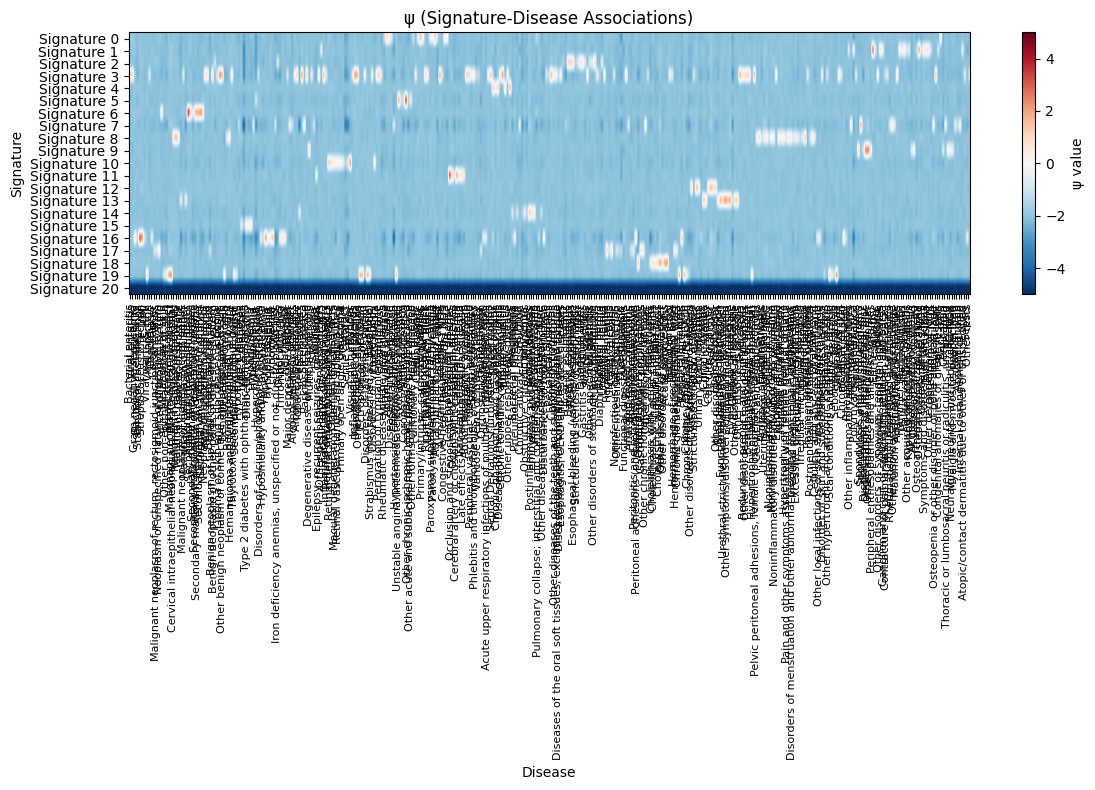

In [21]:
def plot_psi_heatmap(model, disease_names=None, figsize=(12, 8)):
    """
    Plot heatmap of psi values (signature-disease associations)
    
    Args:
        model: The trained model containing psi parameter
        disease_names: Optional list of disease names
        figsize: Tuple specifying figure size
    """
    plt.figure(figsize=figsize)
    
    # Get psi values from model
    psi = model.psi.detach().numpy()
    
    # Create heatmap
    im = plt.imshow(psi, aspect='auto', cmap='RdBu_r', vmin=-5, vmax=5)
    
    # Add colorbar
    plt.colorbar(im, label='ψ value')
    
    # Labels
    plt.xlabel('Disease')
    plt.ylabel('Signature')
    plt.title('ψ (Signature-Disease Associations)')
    
    # Optional: Add disease names if provided
    if disease_names is not None:
        plt.xticks(range(len(disease_names)), disease_names, 
                  rotation=90, fontsize=8)
    
    # Signature labels
    plt.yticks(range(psi.shape[0]), [f'Signature {i}' for i in range(psi.shape[0])])
    
    plt.tight_layout()
    plt.show()

# Usage:
plot_psi_heatmap(model, disease_names=essentials['disease_names'])  # if you have disease names
# or simply:
# plot_psi_heatmap(model)

In [25]:
# Define conditions with their indices and thresholds
conditions = {
    'Breast Cancer': {
        'index': 17,
        'early': 50,
        'late': 70
    },
    'Major Depression': {
        'index': 66,
        'early': 40,
        'late': 60
    },
    'Coronary Atherosclerosis': {
        'index': 112,
        'early': 50,
        'late': 70
    },
    'Atrial Fibrillation': {
        'index': 127,
        'early': 55,
        'late': 75
    },
    'Stroke': {
        'index': 132,
        'early': 55,
        'late': 75
    }
}



Analyzing Breast Cancer (index 17)
Found 423 patients


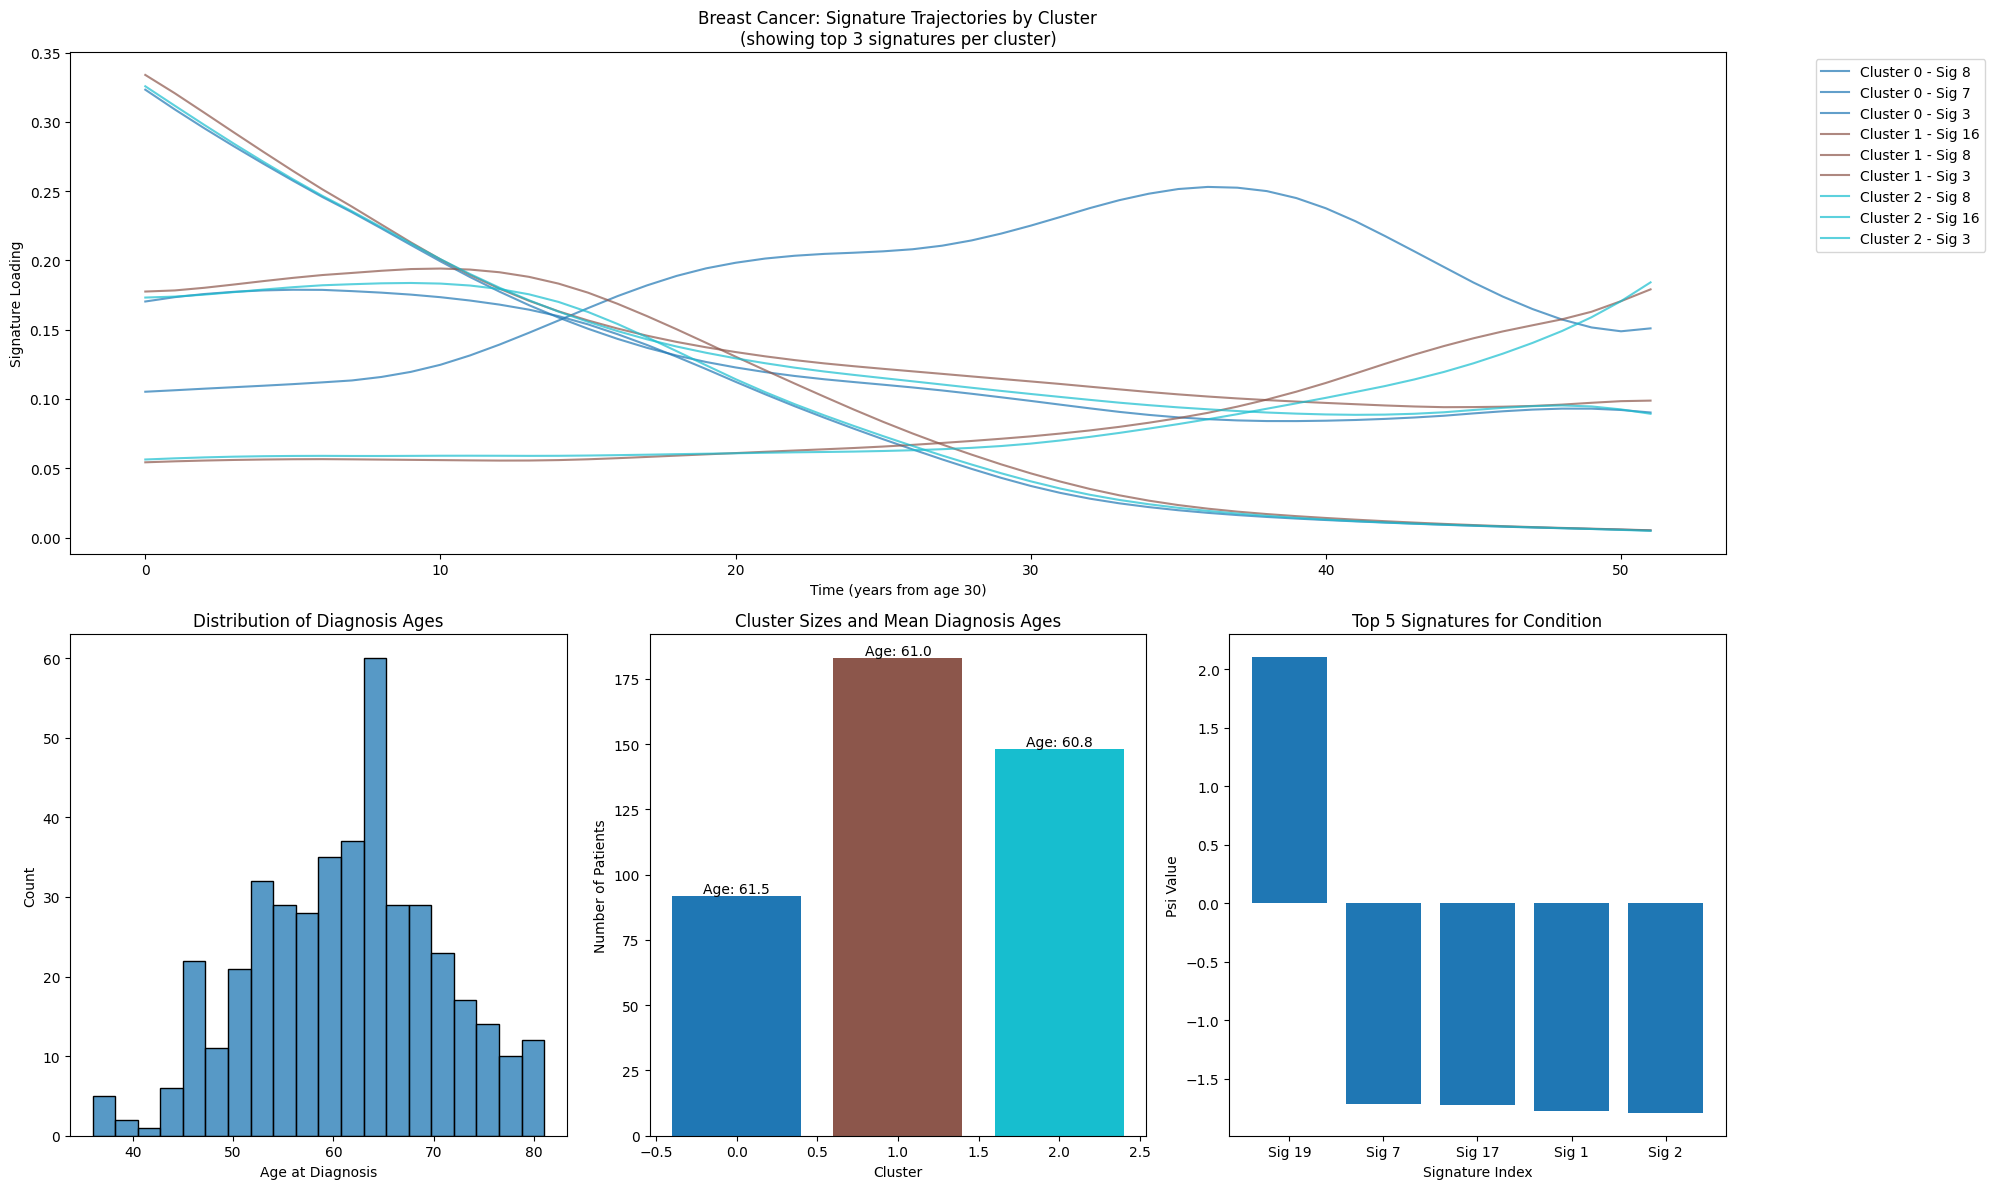


Cluster Summary:

Cluster 0:
Patients: 92
Mean diagnosis age: 61.5
Age range: 36.0 - 80.0

Cluster 1:
Patients: 183
Mean diagnosis age: 61.0
Age range: 37.0 - 81.0

Cluster 2:
Patients: 148
Mean diagnosis age: 60.8
Age range: 37.0 - 81.0

Analyzing Major Depression (index 66)
Found 723 patients


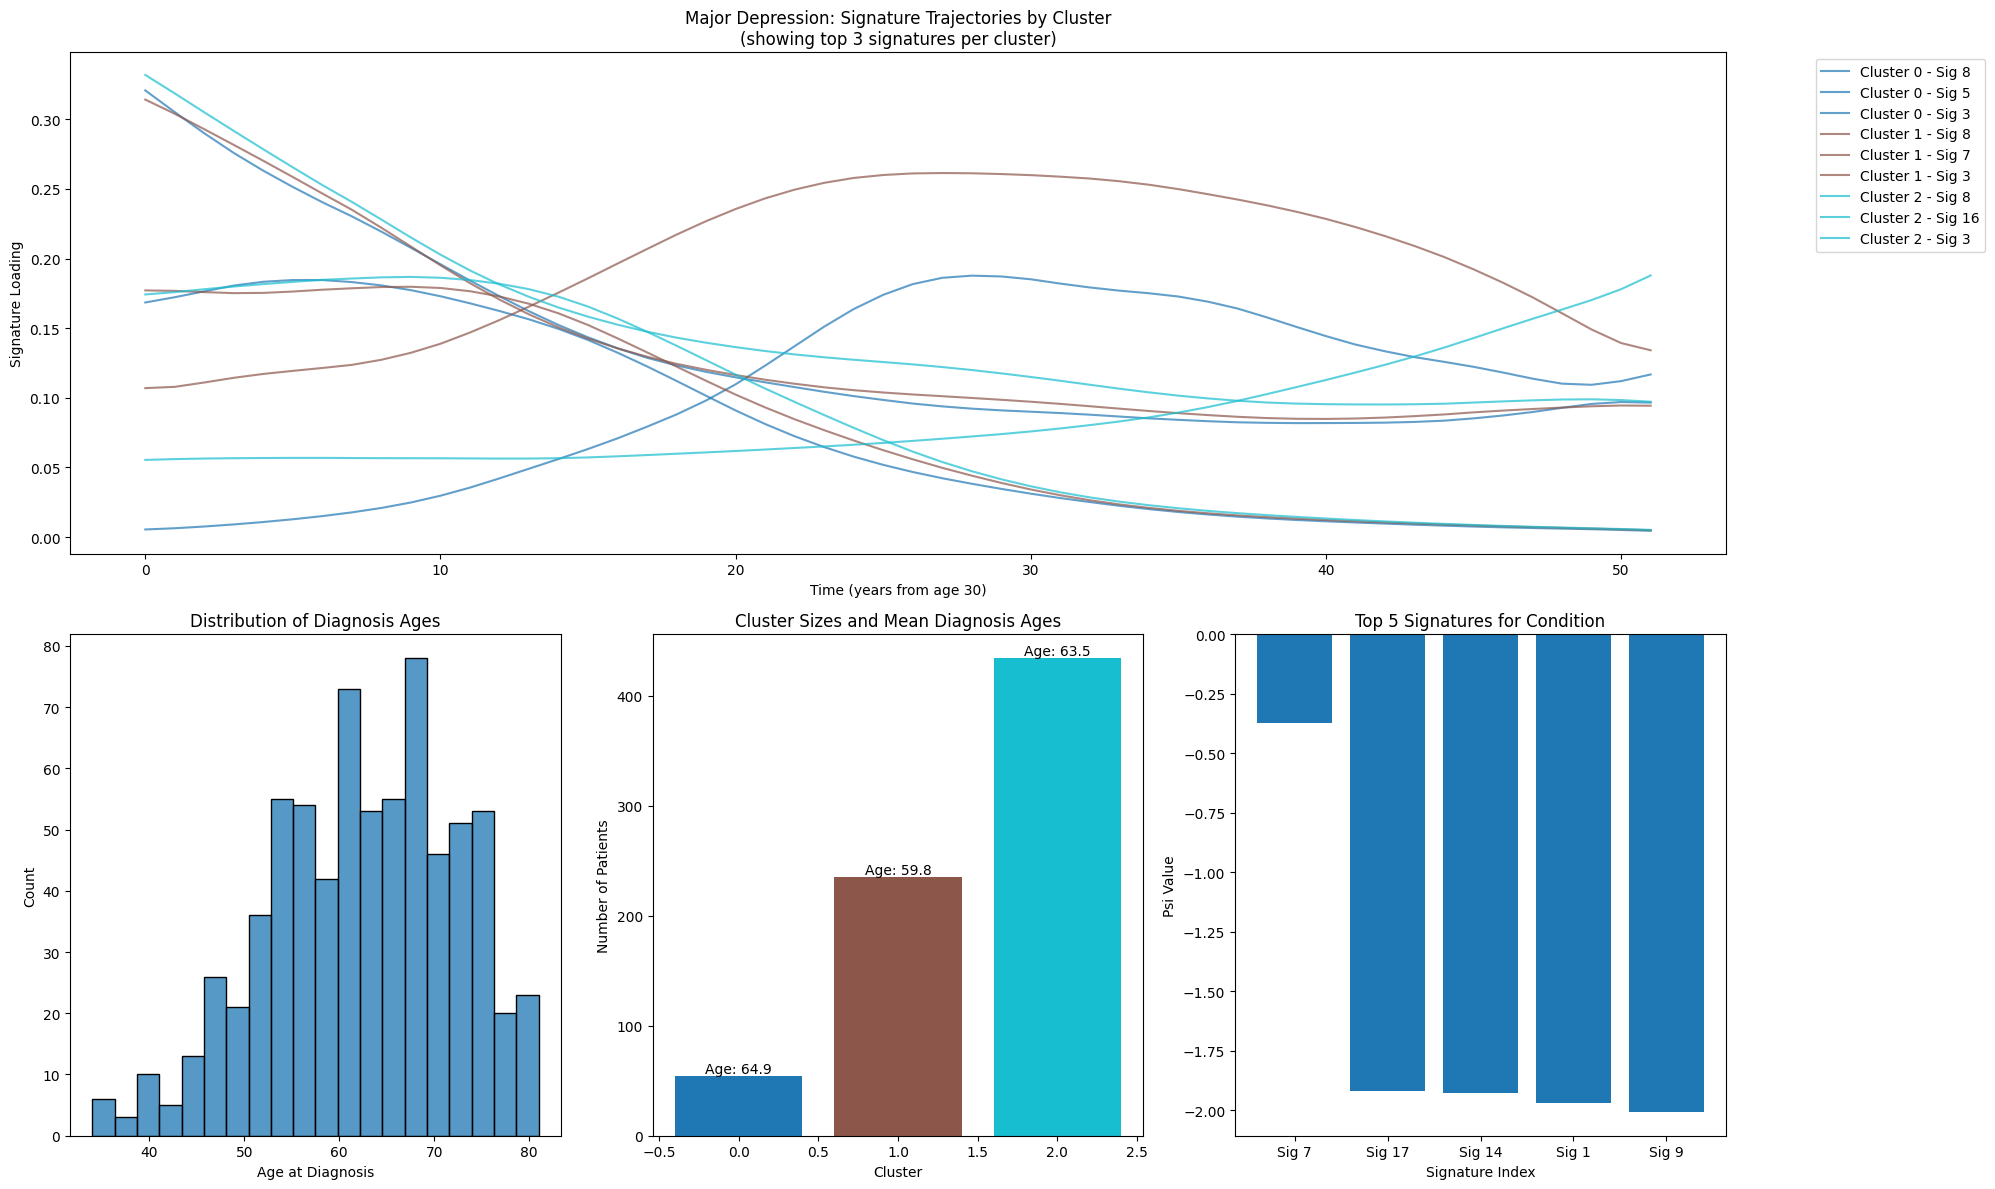


Cluster Summary:

Cluster 0:
Patients: 54
Mean diagnosis age: 64.9
Age range: 41.0 - 80.0

Cluster 1:
Patients: 235
Mean diagnosis age: 59.8
Age range: 34.0 - 79.0

Cluster 2:
Patients: 434
Mean diagnosis age: 63.5
Age range: 34.0 - 81.0

Analyzing Coronary Atherosclerosis (index 112)
Found 635 patients


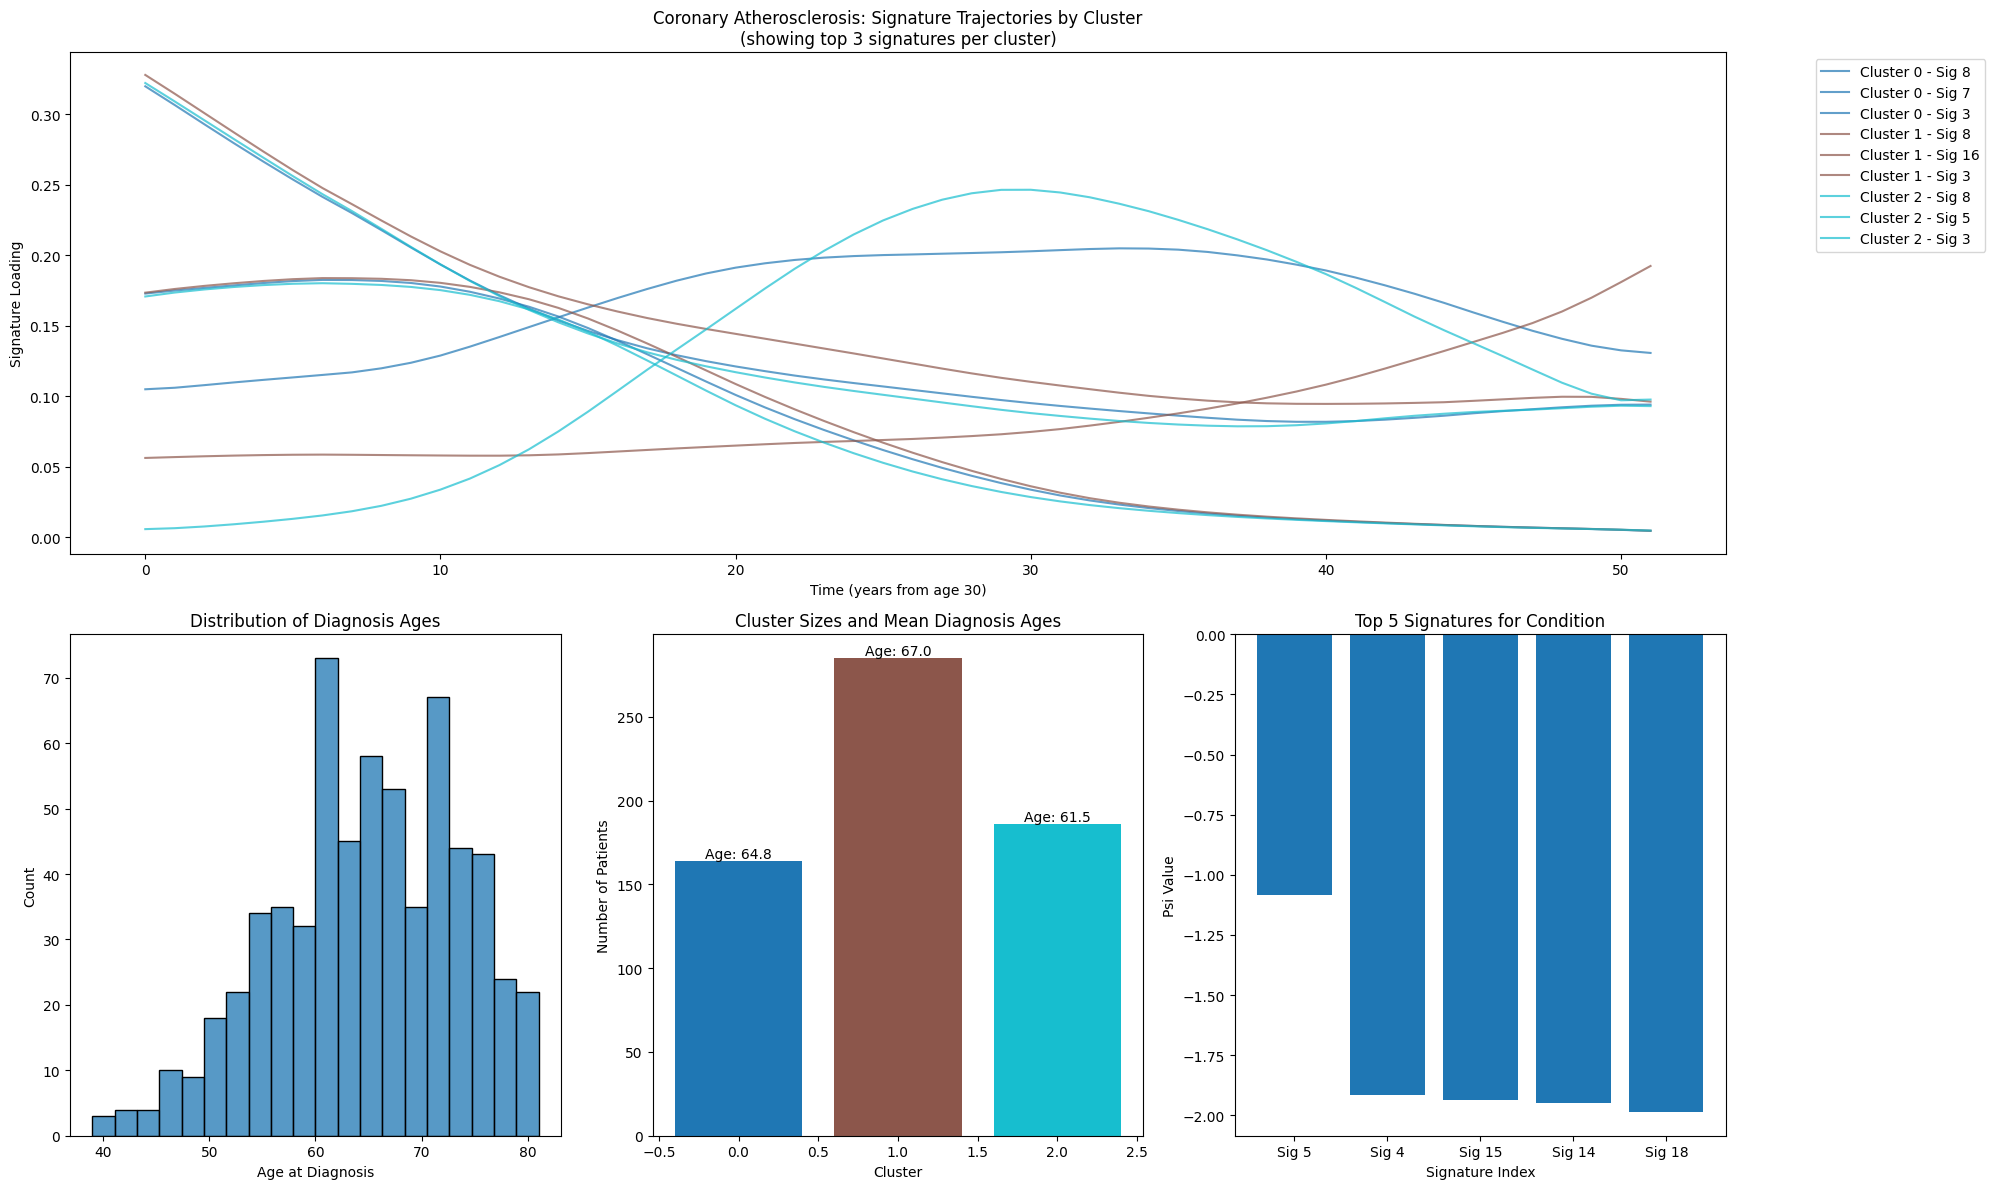


Cluster Summary:

Cluster 0:
Patients: 164
Mean diagnosis age: 64.8
Age range: 39.0 - 81.0

Cluster 1:
Patients: 285
Mean diagnosis age: 67.0
Age range: 41.0 - 81.0

Cluster 2:
Patients: 186
Mean diagnosis age: 61.5
Age range: 40.0 - 80.0

Analyzing Atrial Fibrillation (index 127)
Found 518 patients


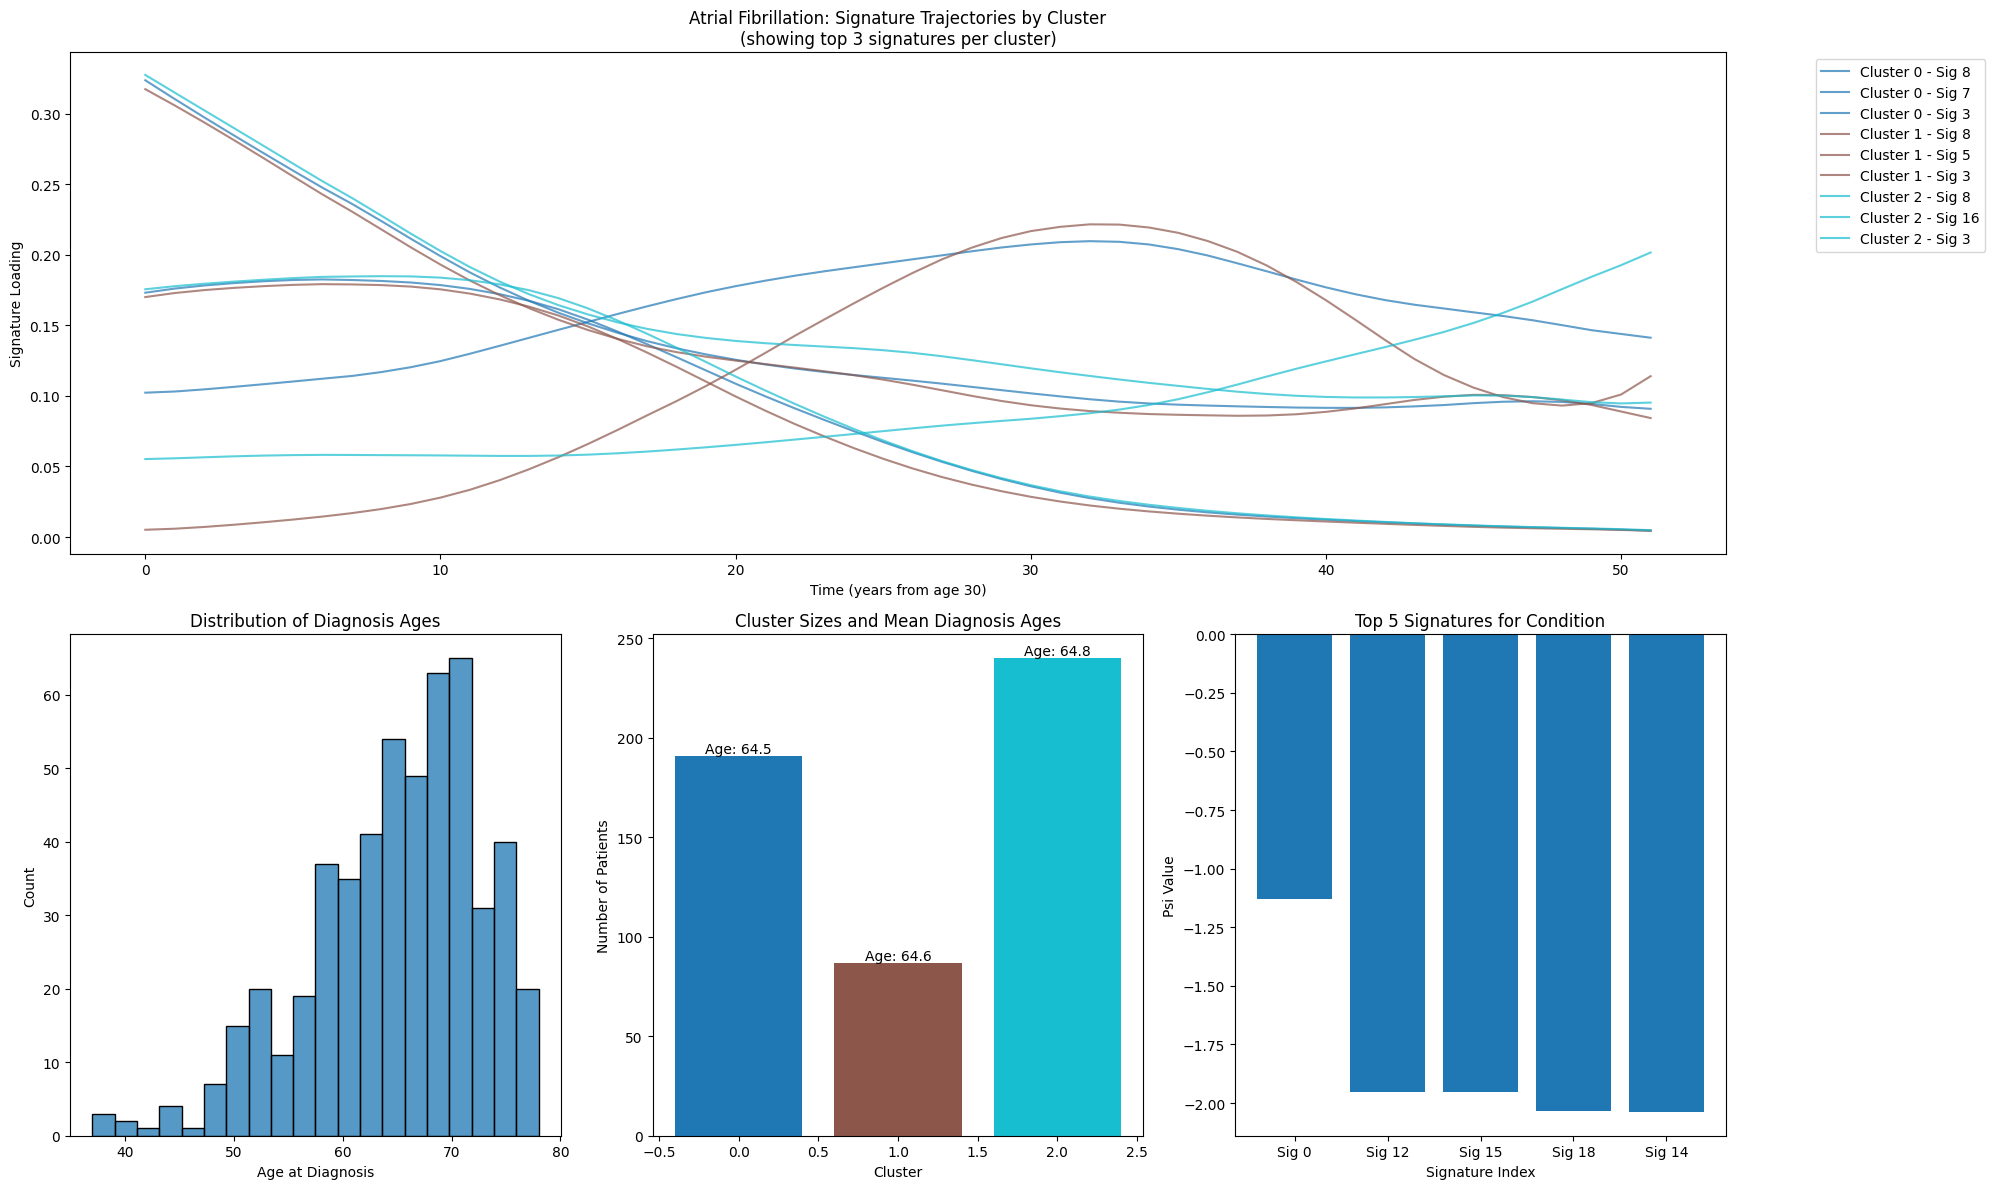


Cluster Summary:

Cluster 0:
Patients: 191
Mean diagnosis age: 64.5
Age range: 38.0 - 78.0

Cluster 1:
Patients: 87
Mean diagnosis age: 64.6
Age range: 46.0 - 78.0

Cluster 2:
Patients: 240
Mean diagnosis age: 64.8
Age range: 37.0 - 78.0

Analyzing Stroke (index 132)
Found 119 patients


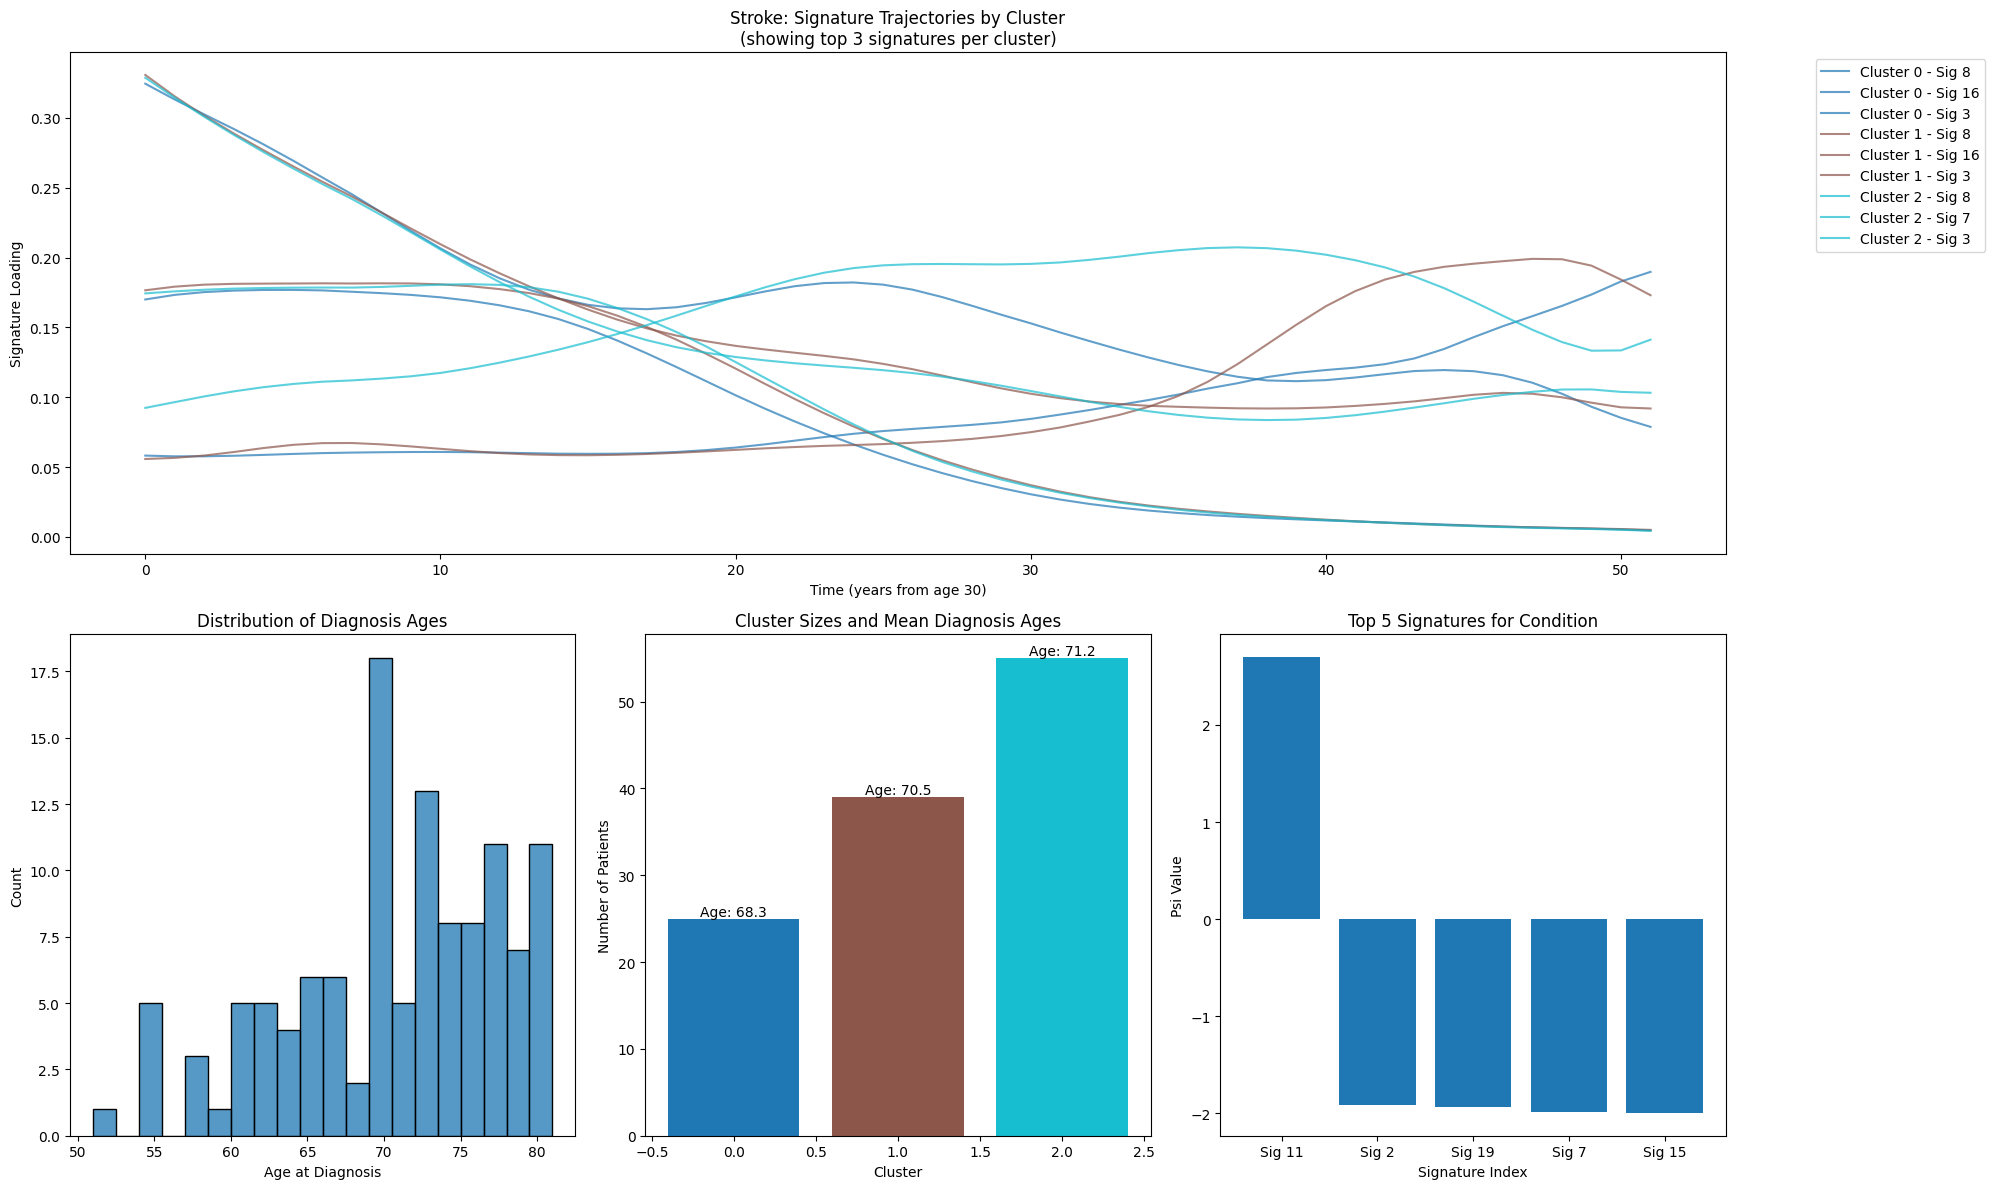


Cluster Summary:

Cluster 0:
Patients: 25
Mean diagnosis age: 68.3
Age range: 51.0 - 79.0

Cluster 1:
Patients: 39
Mean diagnosis age: 70.5
Age range: 54.0 - 81.0

Cluster 2:
Patients: 55
Mean diagnosis age: 71.2
Age range: 54.0 - 81.0


In [27]:
def analyze_disease_heterogeneity(model, conditions, n_clusters=3):
    for condition_name, params in conditions.items():
        print(f"\nAnalyzing {condition_name} (index {params['index']})")
        print("=" * 50)
        
        # Rest of the function remains the same, but use params['index'] instead of condition_idx
        condition_idx = params['index']
        early_threshold = params['early']
        late_threshold = params['late']
        

        
        # Find patients with this condition
        patients = []
        diagnosis_times = []
        
        for p in range(model.Y.shape[0]):
            if torch.any(model.Y[p, condition_idx]):
                patients.append(p)
                diag_time = torch.where(model.Y[p, condition_idx])[0][0].item()
                diagnosis_times.append(diag_time)
        
        if not patients:
            print(f"No patients found with {condition_name}")
            continue
            
        print(f"Found {len(patients)} patients")
        
        # Get signature proportions for these patients
        patient_features = []
        all_trajectories = []
        
        for p in patients:
            # Get full trajectory
            props = torch.softmax(model.lambda_[p], dim=0).detach().numpy()
            all_trajectories.append(props)
            
            # Get features for clustering (mean proportions)
            mean_props = props.mean(axis=1)
            patient_features.append(mean_props)
        
        # Cluster patients
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(patient_features)
        
        # Create visualization
        fig = plt.figure(figsize=(20, 12))
        gs = plt.GridSpec(2, 3, figure=fig)
        
        # Plot 1: Average trajectories for each cluster
        ax1 = fig.add_subplot(gs[0, :])
        cluster_colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
        
        for i in range(n_clusters):
            cluster_patients = [p for j, p in enumerate(patients) if clusters[j] == i]
            cluster_trajectories = [all_trajectories[j] for j, p in enumerate(patients) if clusters[j] == i]
            mean_trajectory = np.mean(cluster_trajectories, axis=0)
            
            # Plot mean trajectory for top signatures
            top_sigs = np.argsort(mean_trajectory.max(axis=1))[-3:]  # Top 3 signatures
            for sig in top_sigs:
                ax1.plot(mean_trajectory[sig], 
                        color=cluster_colors[i], 
                        label=f'Cluster {i} - Sig {sig}',
                        alpha=0.7)
        
        ax1.set_title(f'{condition_name}: Signature Trajectories by Cluster\n(showing top 3 signatures per cluster)')
        ax1.set_xlabel('Time (years from age 30)')
        ax1.set_ylabel('Signature Loading')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Plot 2: Diagnosis age distribution
        ax2 = fig.add_subplot(gs[1, 0])
        diagnosis_ages = [30 + t for t in diagnosis_times]
        sns.histplot(diagnosis_ages, bins=20, ax=ax2)
        ax2.set_title('Distribution of Diagnosis Ages')
        ax2.set_xlabel('Age at Diagnosis')
        
        # Plot 3: Cluster characteristics
        ax3 = fig.add_subplot(gs[1, 1])
        cluster_sizes = [np.sum(clusters == i) for i in range(n_clusters)]
        cluster_mean_ages = [np.mean([30 + diagnosis_times[j] for j, c in enumerate(clusters) if c == i]) 
                           for i in range(n_clusters)]
        
        ax3.bar(range(n_clusters), cluster_sizes, color=cluster_colors)
        ax3.set_title('Cluster Sizes and Mean Diagnosis Ages')
        ax3.set_xlabel('Cluster')
        ax3.set_ylabel('Number of Patients')
        
        # Add mean ages as text
        for i, (size, age) in enumerate(zip(cluster_sizes, cluster_mean_ages)):
            ax3.text(i, size, f'Age: {age:.1f}', ha='center', va='bottom')
        
        # Plot 4: Signature importance
        ax4 = fig.add_subplot(gs[1, 2])
        psi_values = model.psi[:, condition_idx].detach().numpy()
        top_sigs = np.argsort(psi_values)[-5:][::-1]
        ax4.bar(range(5), psi_values[top_sigs])
        ax4.set_title('Top 5 Signatures for Condition')
        ax4.set_xlabel('Signature Index')
        ax4.set_ylabel('Psi Value')
        ax4.set_xticks(range(5))
        ax4.set_xticklabels([f'Sig {i}' for i in top_sigs])
        
        plt.tight_layout()
        plt.show()
        
        # Print statistical summary
        print("\nCluster Summary:")
        for i in range(n_clusters):
            cluster_patients = [p for j, p in enumerate(patients) if clusters[j] == i]
            cluster_diag_ages = [30 + diagnosis_times[j] for j, p in enumerate(patients) if clusters[j] == i]
            print(f"\nCluster {i}:")
            print(f"Patients: {len(cluster_patients)}")
            print(f"Mean diagnosis age: {np.mean(cluster_diag_ages):.1f}")
            print(f"Age range: {min(cluster_diag_ages):.1f} - {max(cluster_diag_ages):.1f}")



# Run the analysis
from sklearn.cluster import KMeans
import seaborn as sns
analyze_disease_heterogeneity(model, conditions)

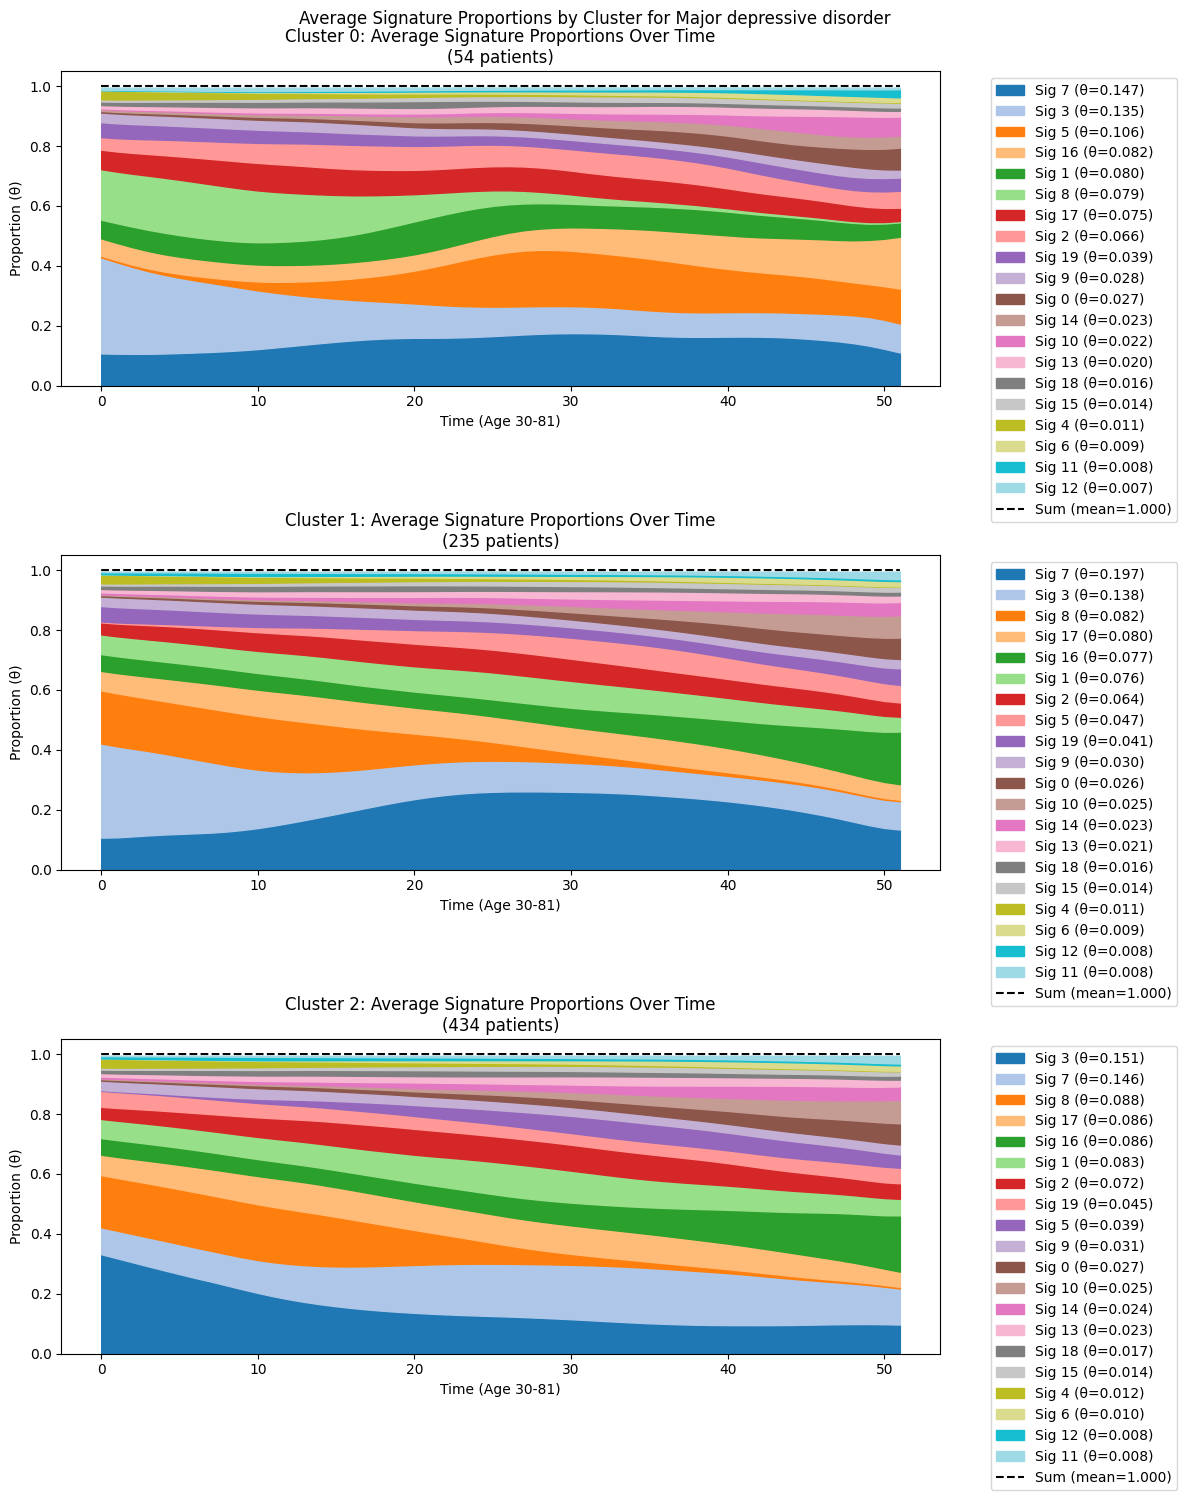

In [31]:
def plot_cluster_signature_proportions(model, condition_idx, clusters, n_top_sigs=20):
    """
    Plot average signature proportions over time for each cluster of patients with a condition
    """
    # Find patients with this condition and their diagnosis times
    patients = []
    diagnosis_times = []
    
    for p in range(model.Y.shape[0]):
        if torch.any(model.Y[p, condition_idx]):
            patients.append(p)
            diag_time = torch.where(model.Y[p, condition_idx])[0][0].item()
            diagnosis_times.append(diag_time)
    
    # Get features for clustering
    patient_features = []
    for p in patients:
        props = torch.softmax(model.lambda_[p], dim=0).detach().numpy()
        mean_props = props.mean(axis=1)
        patient_features.append(mean_props)
    
    # Perform clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    patient_clusters = kmeans.fit_predict(patient_features)
    
    # Now create the visualization
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    time_points = np.arange(model.T)
    
    for cluster_idx in range(3):
        # Get patients in this cluster using the clusters we just created
        cluster_patients = [p for i, p in enumerate(patients) if patient_clusters[i] == cluster_idx]
        
        # Calculate average theta for this cluster
        cluster_thetas = []
        for p in cluster_patients:
            theta = torch.softmax(model.lambda_[p], dim=0).detach().numpy()
            cluster_thetas.append(theta)
        avg_theta = np.mean(cluster_thetas, axis=0)  # [K x T]
        
        # Calculate mean proportion for each signature
        mean_props = avg_theta.mean(axis=1)
        
        # Get top signatures by mean proportion
        top_sig_idx = np.argsort(mean_props)[-n_top_sigs:][::-1]
        
        # Create stacked area plot
        bottom = np.zeros(model.T)
        colors = plt.cm.tab20(np.linspace(0, 1, n_top_sigs))
        
        for i, sig in enumerate(top_sig_idx):
            axes[cluster_idx].fill_between(time_points, bottom, bottom + avg_theta[sig], 
                                         label=f'Sig {sig} (θ={mean_props[sig]:.3f})',
                                         color=colors[i])
            bottom += avg_theta[sig]
        
        # Add sum line
        axes[cluster_idx].plot(time_points, np.sum(avg_theta, axis=0), 'k--', 
                             label=f'Sum (mean={np.mean(np.sum(avg_theta, axis=0)):.3f})')
        
        axes[cluster_idx].set_title(f'Cluster {cluster_idx}: Average Signature Proportions Over Time\n'
                                  f'({len(cluster_patients)} patients)')
        axes[cluster_idx].set_xlabel('Time (Age 30-81)')
        axes[cluster_idx].set_ylabel('Proportion (θ)')
        axes[cluster_idx].set_ylim(0, 1.05)
        axes[cluster_idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.suptitle(f'Average Signature Proportions by Cluster for {model.disease_names[condition_idx]}')
    plt.tight_layout()
    plt.show()

# Usage:
plot_cluster_signature_proportions(model, condition_idx=66, clusters=None)  # For Major Depression

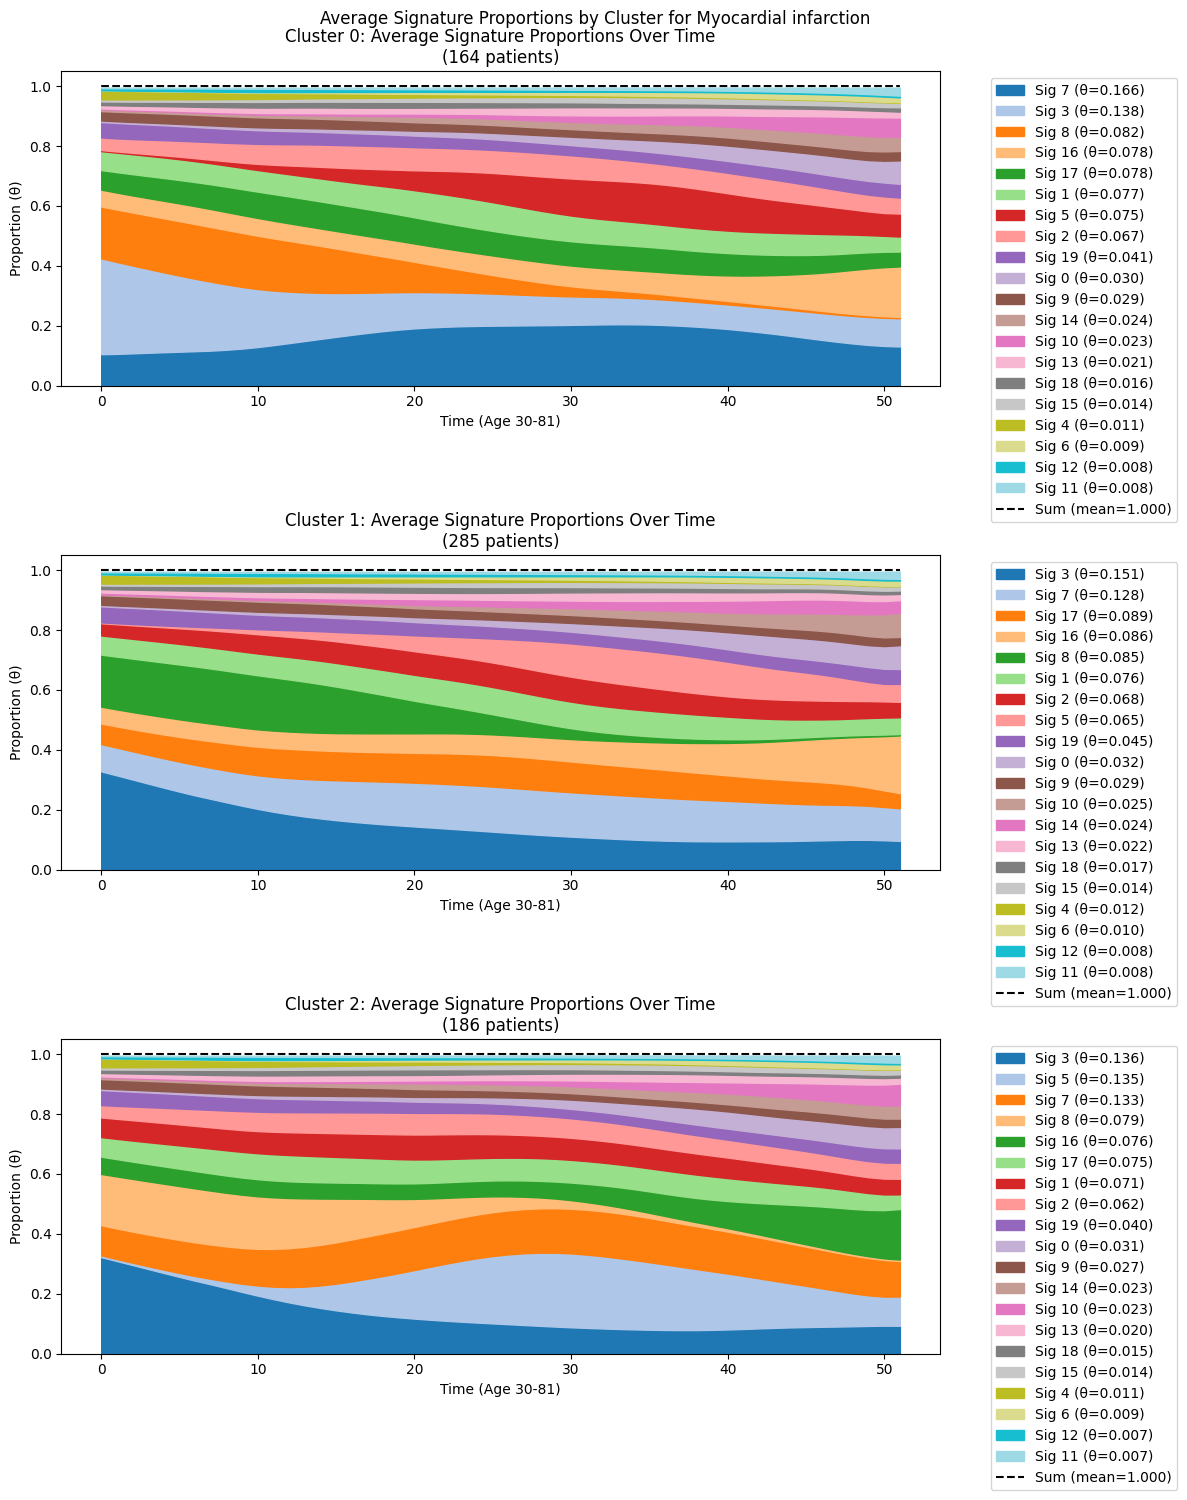

In [32]:
plot_cluster_signature_proportions(model, condition_idx=112, clusters=None) 

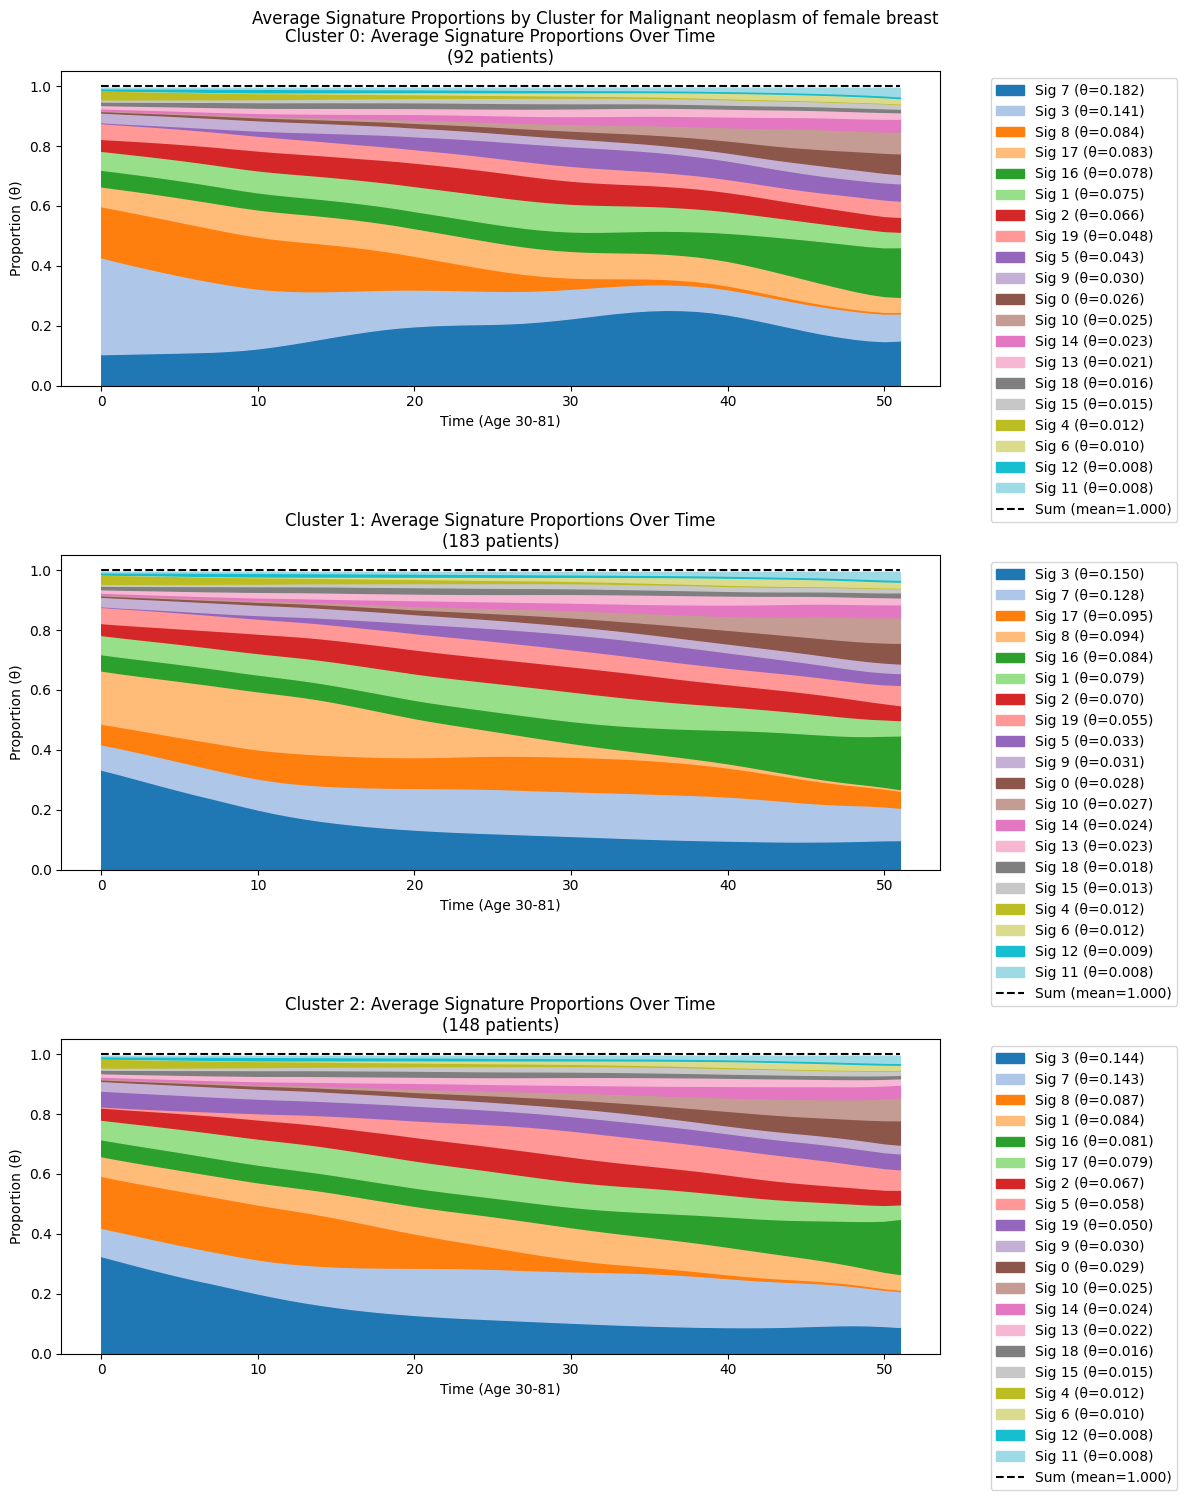

In [33]:
plot_cluster_signature_proportions(model, condition_idx=17, clusters=None) 

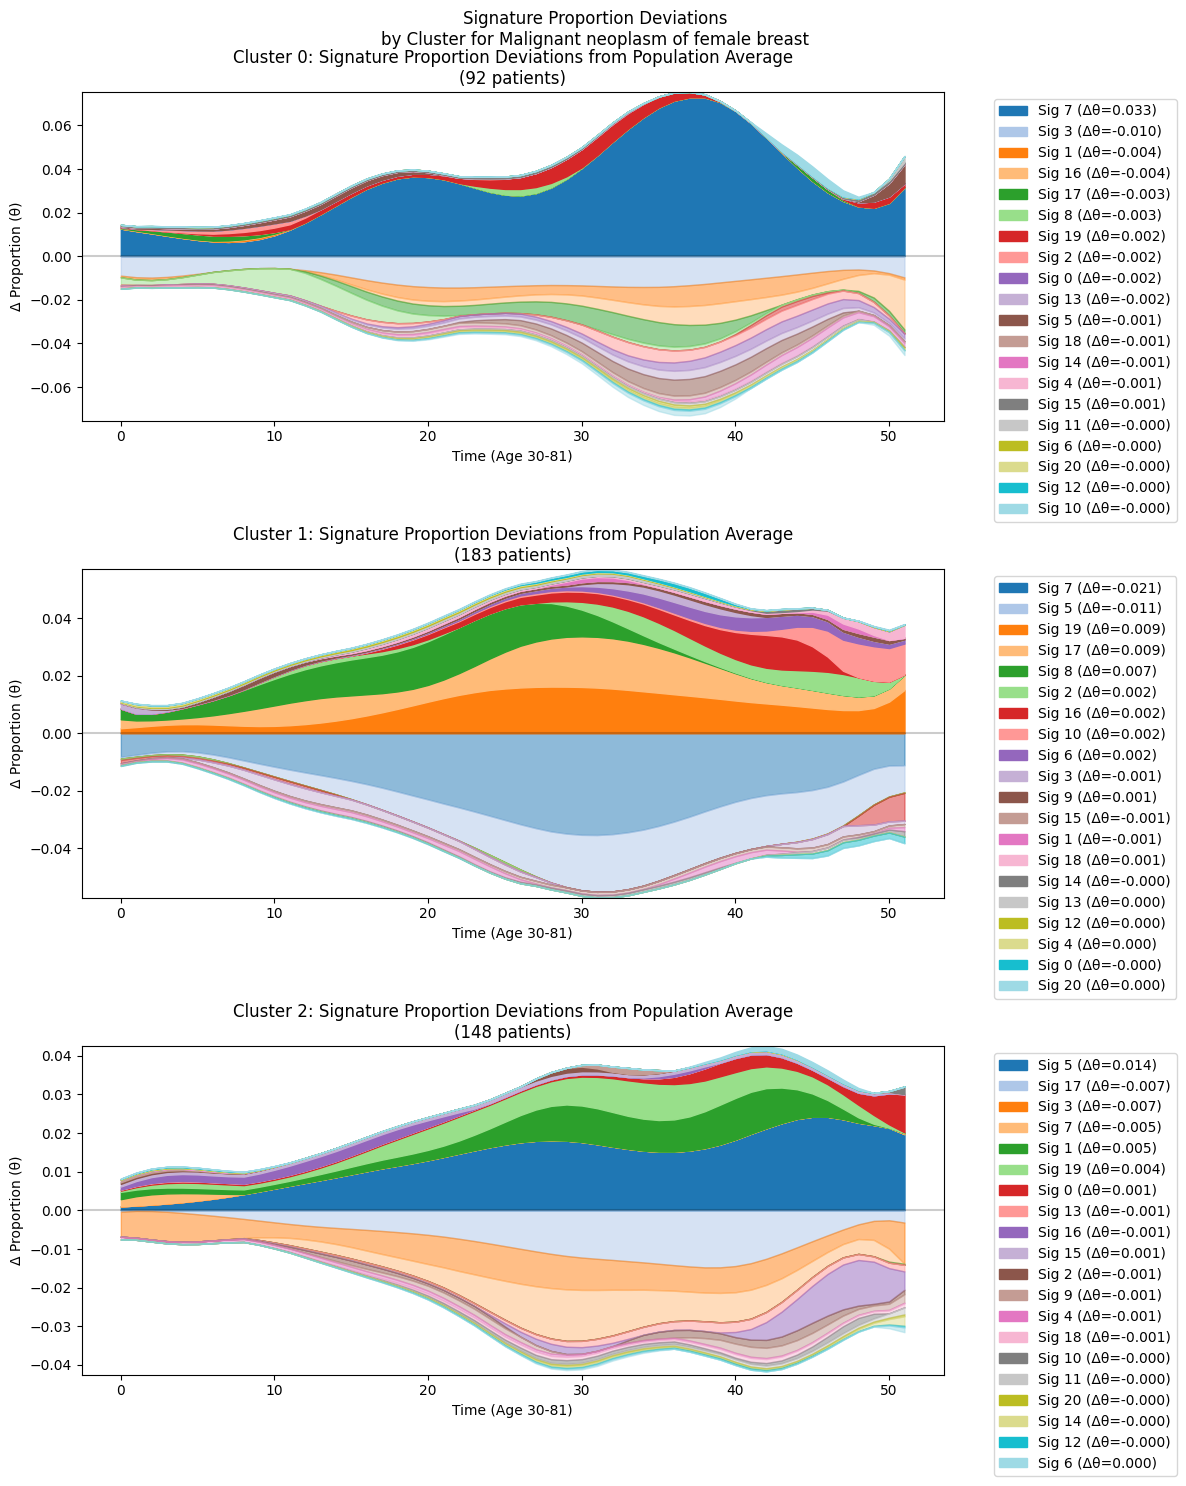

In [44]:
def plot_cluster_signature_proportions(model, condition_idx, n_top_sigs=20, subtract_reference=True):
    """
    Plot average signature proportions over time for each cluster, subtracting signature references
    """
    # Find patients with this condition
    patients = []
    for p in range(model.Y.shape[0]):
        if torch.any(model.Y[p, condition_idx]):
            patients.append(p)
    
    # Get features for clustering
    patient_features = []
    for p in patients:
        props = torch.softmax(model.lambda_[p], dim=0).detach().numpy()
        mean_props = props.mean(axis=1)
        patient_features.append(mean_props)
    
    # Perform clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    patient_clusters = kmeans.fit_predict(patient_features)
    
    # Create figure and axes
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    time_points = np.arange(model.T)
    # Get reference trajectories including healthy state
    if model.healthy_ref is not None:
        # Create full reference including healthy state
        reference_lambda = torch.zeros((model.K_total, model.T))
        reference_lambda[:model.K] = model.signature_refs  # Disease signatures
        reference_lambda[model.K] = model.healthy_ref  # Healthy reference (-5.0)
        # Convert to proportions using softmax
        reference_theta = torch.softmax(reference_lambda, dim=0).detach().numpy()
    else:
        reference_theta = torch.softmax(model.signature_refs, dim=0).detach().numpy()
    
    for cluster_idx in range(3):
        cluster_patients = [p for i, p in enumerate(patients) if patient_clusters[i] == cluster_idx]
        
        # Calculate average theta for this cluster
        cluster_thetas = []
        for p in cluster_patients:
            # Apply softmax to get proportions
            theta = torch.softmax(model.lambda_[p], dim=0).detach().numpy()
            cluster_thetas.append(theta)
        avg_theta = np.mean(cluster_thetas, axis=0)
        
        if subtract_reference:
            # Now subtracting softmax'd values from softmax'd values
            avg_theta = avg_theta - reference_theta
        
        # Calculate mean deviation for each signature
        mean_props = avg_theta.mean(axis=1)
        
        # Get top signatures by absolute mean deviation
        top_sig_idx = np.argsort(np.abs(mean_props))[-n_top_sigs:][::-1]
        
        # Create stacked area plot
        bottom_pos = np.zeros(model.T)
        bottom_neg = np.zeros(model.T)
        colors = plt.cm.tab20(np.linspace(0, 1, n_top_sigs))
        
        for i, sig in enumerate(top_sig_idx):
            values = avg_theta[sig]
            if subtract_reference:
                # For deviations, split positive and negative
                pos_values = np.maximum(values, 0)
                neg_values = np.minimum(values, 0)
                
                axes[cluster_idx].fill_between(time_points, bottom_pos, bottom_pos + pos_values,
                                             label=f'Sig {sig} (Δθ={mean_props[sig]:.3f})',
                                             color=colors[i])
                axes[cluster_idx].fill_between(time_points, bottom_neg, bottom_neg + neg_values,
                                             color=colors[i], alpha=0.5)
                
                bottom_pos += pos_values
                bottom_neg += neg_values
            else:
                axes[cluster_idx].fill_between(time_points, bottom_pos, bottom_pos + values,
                                             label=f'Sig {sig} (θ={mean_props[sig]:.3f})',
                                             color=colors[i])
                bottom_pos += values
        
        title = f'Cluster {cluster_idx}: '
        title += 'Signature Proportion Deviations from Population Average' if subtract_reference else 'Average Signature Proportions'
        title += f'\n({len(cluster_patients)} patients)'
        
        axes[cluster_idx].set_title(title)
        axes[cluster_idx].set_xlabel('Time (Age 30-81)')
        axes[cluster_idx].set_ylabel('Δ Proportion (θ)' if subtract_reference else 'Proportion (θ)')
        axes[cluster_idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        if subtract_reference:
            # Center y-axis around 0 for deviations
            max_dev = max(abs(bottom_pos.max()), abs(bottom_neg.min()))
            axes[cluster_idx].set_ylim(-max_dev, max_dev)
            axes[cluster_idx].axhline(y=0, color='k', linestyle='-', alpha=0.2)
        else:
            axes[cluster_idx].set_ylim(0, 1.05)
    
    plt.suptitle(f'{"Signature Proportion Deviations" if subtract_reference else "Average Signature Proportions"}\n'
                f'by Cluster for {model.disease_names[condition_idx]}')
    plt.tight_layout()
    plt.show()

# Usage:
plot_cluster_signature_proportions(model, 17, n_top_sigs=20, subtract_reference=True)
### small change for git test

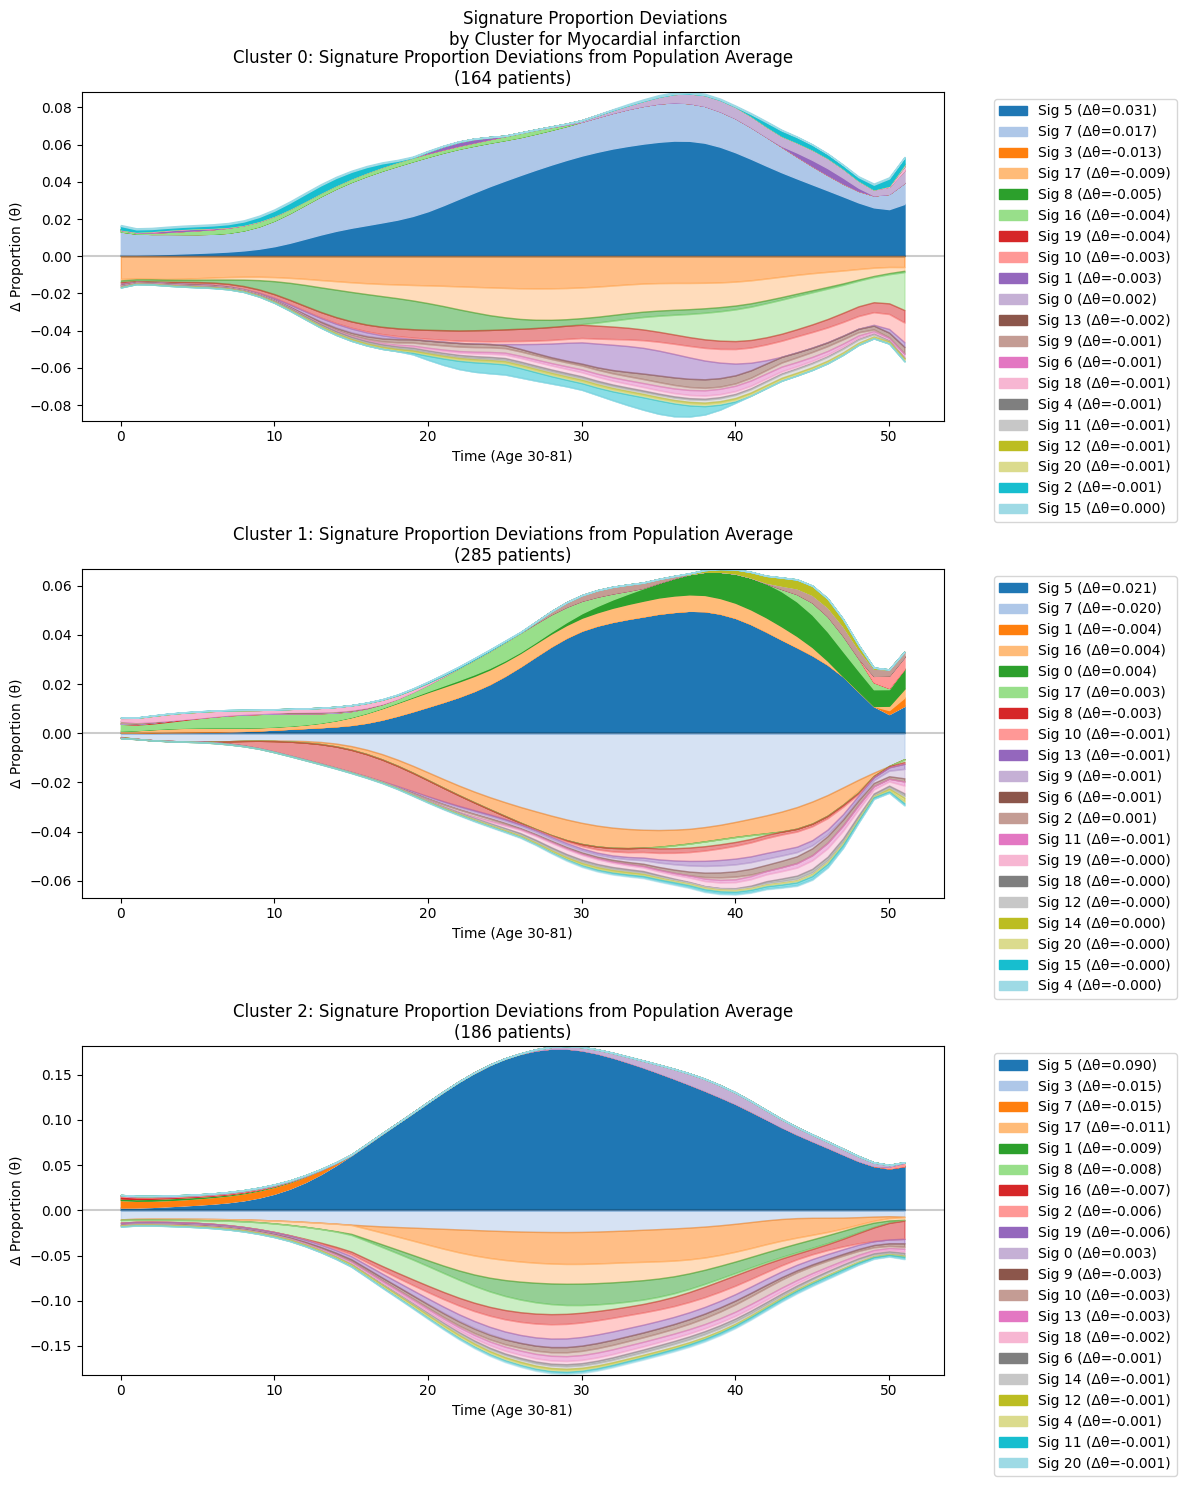

In [45]:

# Usage:
plot_cluster_signature_proportions(model, 112, n_top_sigs=20, subtract_reference=True)

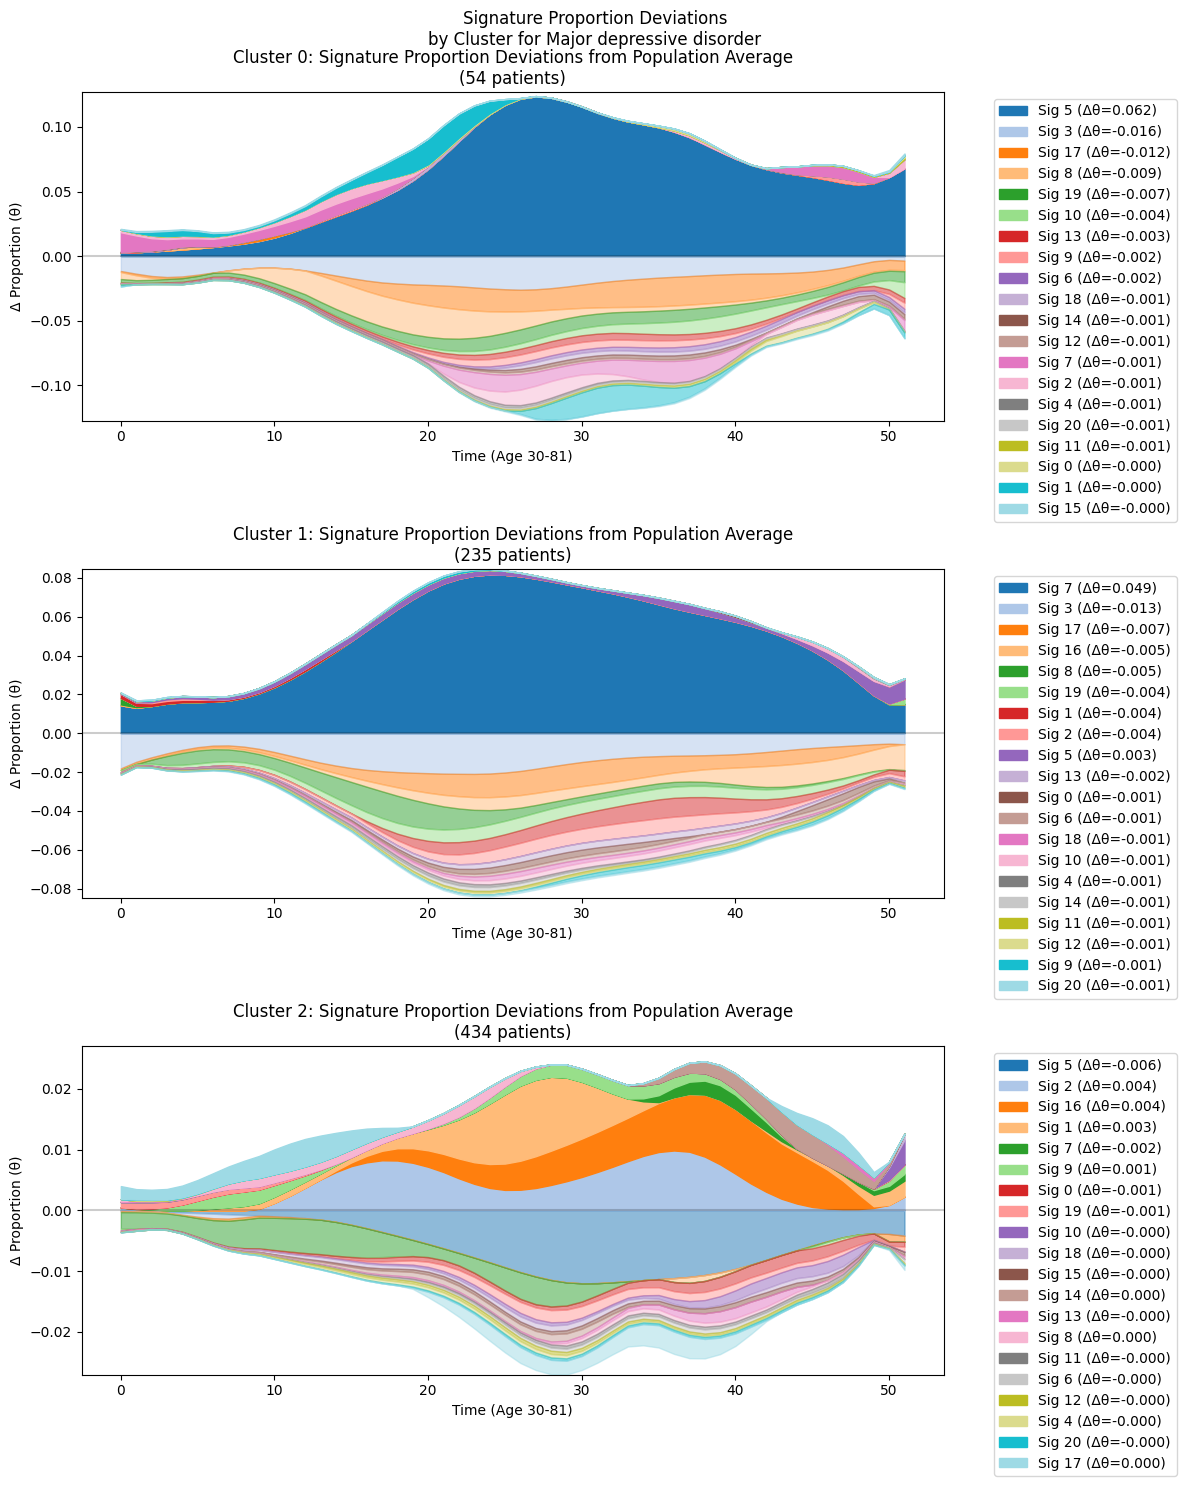

In [46]:
# Usage:
plot_cluster_signature_proportions(model, 66, n_top_sigs=20, subtract_reference=True)

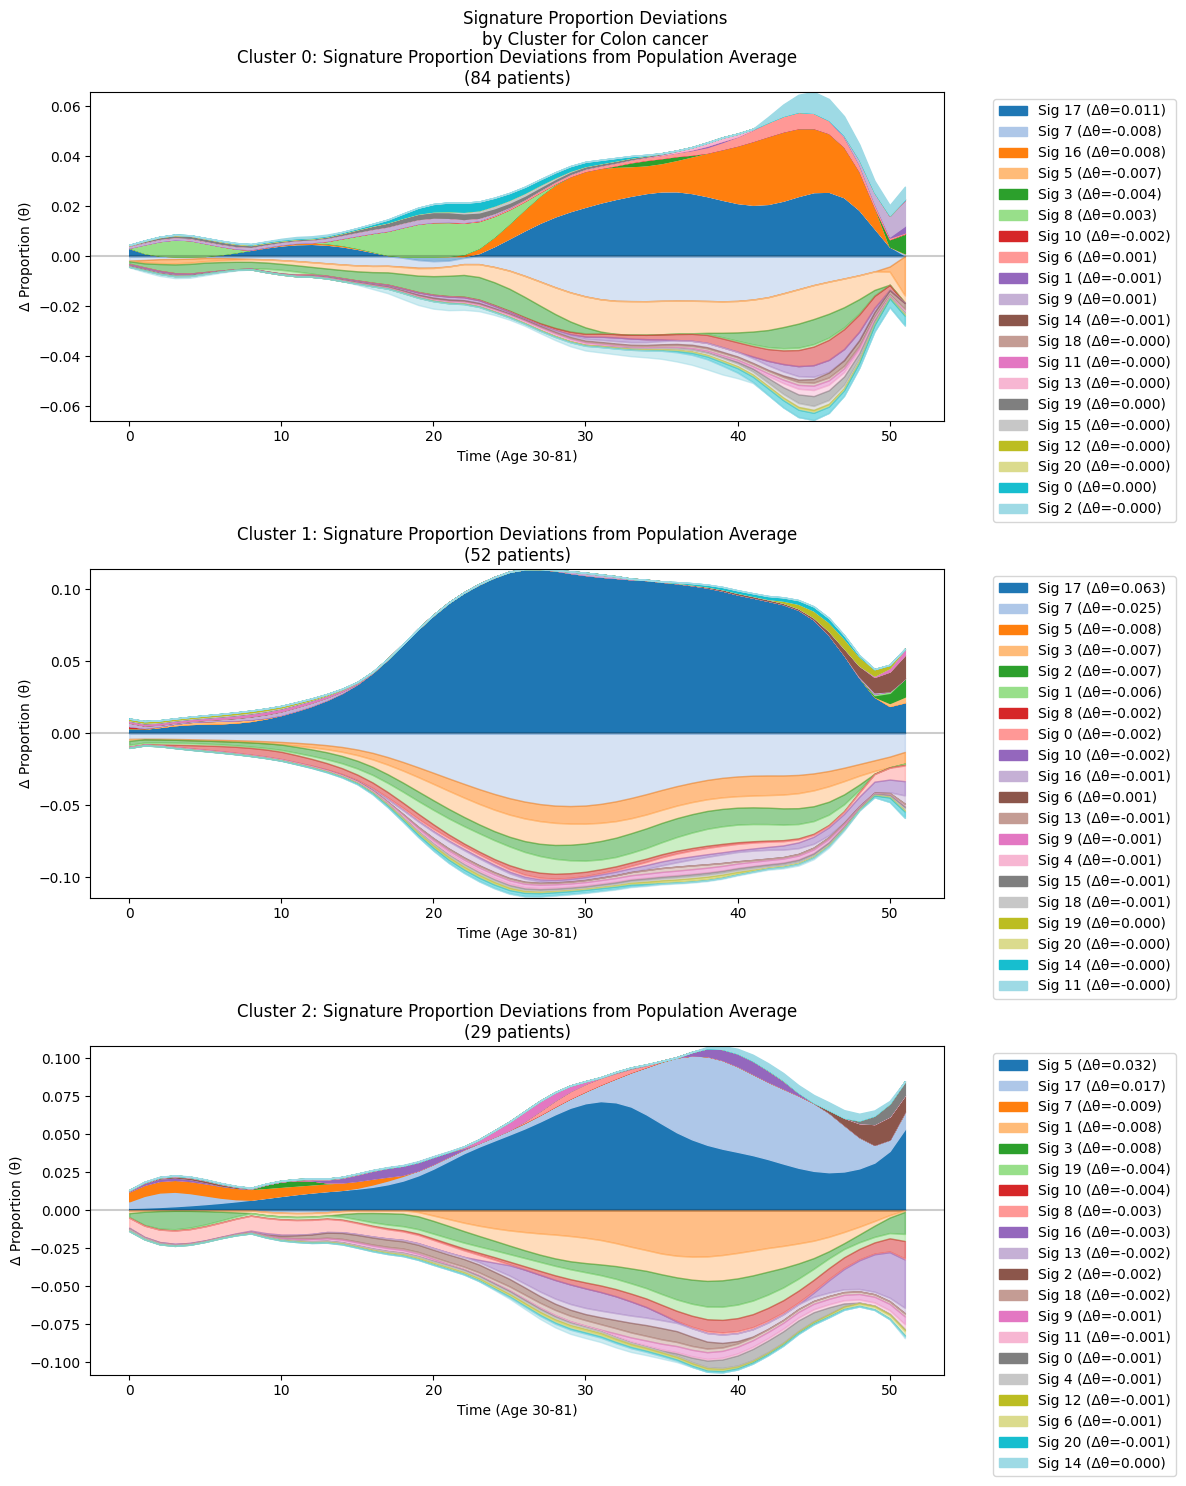

In [47]:
# Usage:
plot_cluster_signature_proportions(model, 10, n_top_sigs=20, subtract_reference=True)

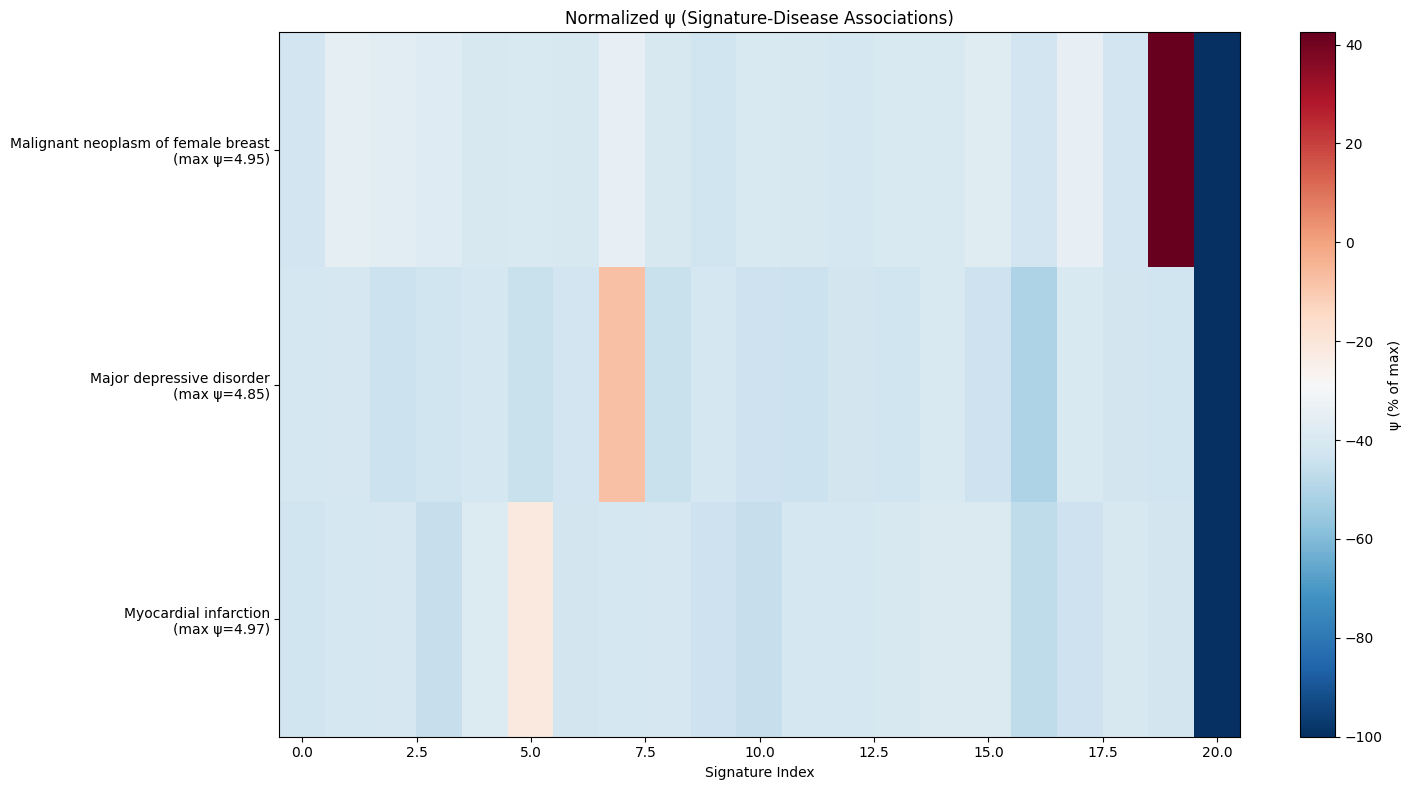


Most Important Signatures by Disease:

Malignant neoplasm of female breast (max ψ=4.95):
  Signature 20: -100.0% of max
  Signature 9: -42.7% of max
  Signature 0: -42.7% of max
  Signature 16: -42.5% of max
  Signature 19: 42.5% of max

Major depressive disorder (max ψ=4.85):
  Signature 20: -100.0% of max
  Signature 16: -50.7% of max
  Signature 8: -44.7% of max
  Signature 5: -44.5% of max
  Signature 2: -44.3% of max

Myocardial infarction (max ψ=4.97):
  Signature 20: -100.0% of max
  Signature 16: -47.0% of max
  Signature 10: -45.3% of max
  Signature 3: -45.1% of max
  Signature 9: -43.5% of max


In [53]:
def analyze_psi_importance(model, condition_indices, n_top_sigs=5):
    """
    Analyze signature importance across diseases using normalized psi values (% of max)
    """
    disease_patterns = {}
    
    for condition_idx in condition_indices:
        # Get psi values for this disease
        psi_disease = model.psi[:, condition_idx].detach().numpy()
        
        # Normalize to percent of max
        psi_max = np.max(np.abs(psi_disease))
        psi_normalized = (psi_disease / psi_max) * 100
        
        # Store patterns
        top_sigs = np.argsort(np.abs(psi_disease))[-n_top_sigs:][::-1]
        disease_patterns[condition_idx] = {
            'disease_name': model.disease_names[condition_idx],
            'top_signatures': top_sigs,
            'psi_values': psi_normalized,  # Store normalized values
            'max_psi': psi_max  # Store max for reference
        }
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(15, 8))
    
    diseases = list(disease_patterns.keys())
    y_pos = np.arange(len(diseases))
    
    # Create heatmap
    signature_matrix = np.zeros((len(diseases), model.K_total))
    for i, d in enumerate(diseases):
        signature_matrix[i, :] = disease_patterns[d]['psi_values']
    
    im = ax.imshow(signature_matrix, aspect='auto', cmap='RdBu_r')
    plt.colorbar(im, label='ψ (% of max)')
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{disease_patterns[d]['disease_name']}\n(max ψ={disease_patterns[d]['max_psi']:.2f})" 
                        for d in diseases])
    ax.set_xlabel('Signature Index')
    ax.set_title('Normalized ψ (Signature-Disease Associations)')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nMost Important Signatures by Disease:")
    for d in diseases:
        print(f"\n{disease_patterns[d]['disease_name']} (max ψ={disease_patterns[d]['max_psi']:.2f}):")
        top_sigs = disease_patterns[d]['top_signatures']
        psi_vals = disease_patterns[d]['psi_values']
        for sig in top_sigs:
            print(f"  Signature {sig}: {psi_vals[sig]:.1f}% of max")

# Usage:
conditions = [17, 66, 112]  # Breast Cancer, Major Depression, MI
analyze_psi_importance(model, conditions)

In [57]:
checkpoint['initial_state']['psi']

tensor([[-2.0162, -1.9909, -1.9982,  ..., -1.9936, -1.9885, -2.0048],
        [-2.0034, -1.9774, -2.0040,  ..., -1.9989, -2.0033, -1.9827],
        [-1.9909, -1.9892, -2.0000,  ..., -1.9940, -1.9808, -2.0092],
        ...,
        [-2.0022, -1.9927, -1.9903,  ..., -1.9766, -2.0031, -2.0167],
        [-1.9907, -1.9997, -1.9918,  ..., -1.9948, -1.9953, -1.9874],
        [-5.0113, -5.0115, -5.0025,  ..., -4.9993, -4.9923, -5.0097]])

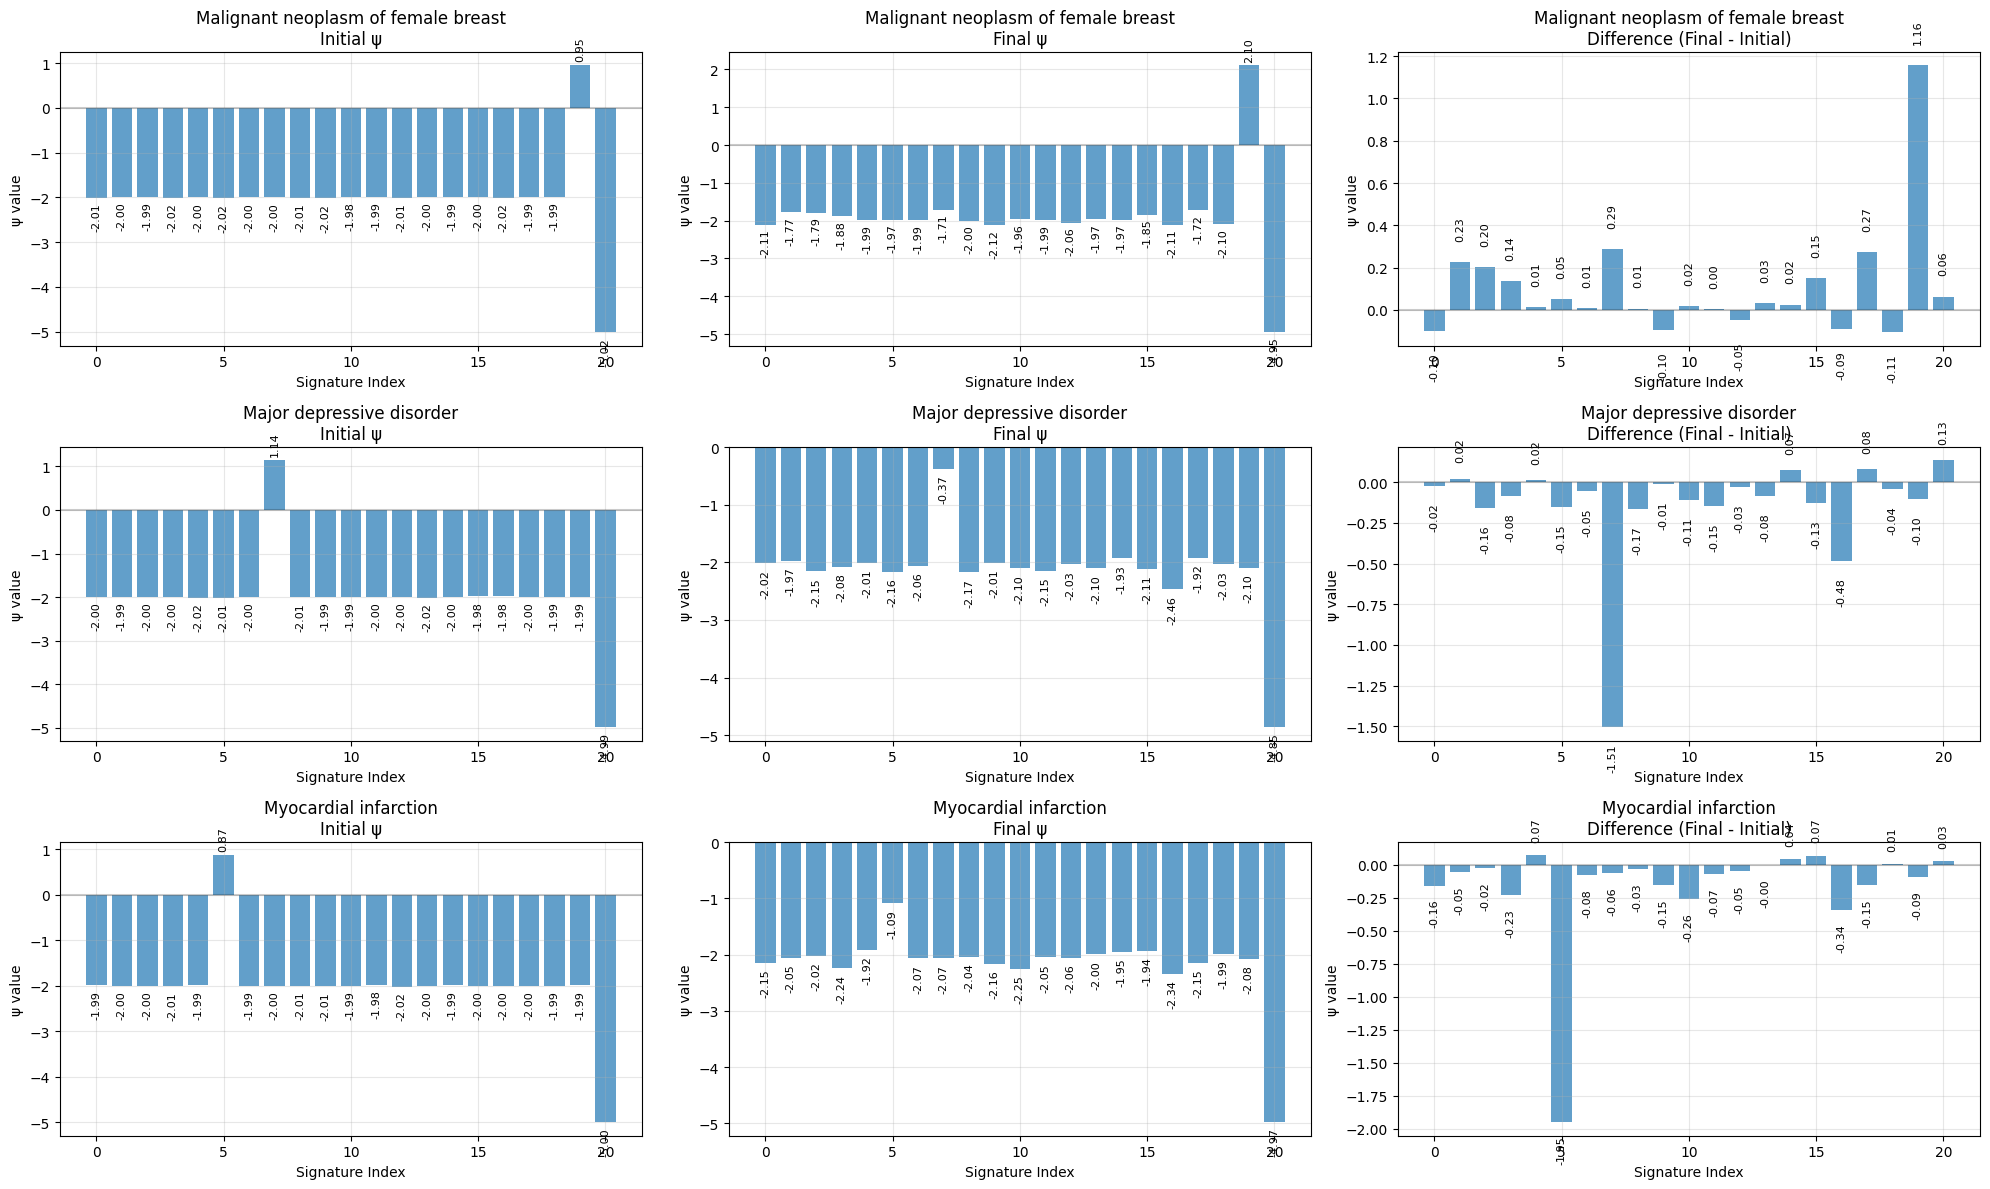

In [76]:
def visualize_psi_changes(model, checkpoint, condition_indices):
    """
    Visualize initial psi, final psi, and their difference for each disease
    """
    # Get initial and final psi
    initial_psi = checkpoint['initial_state']['psi']
    final_psi = model.psi
    
    fig, axes = plt.subplots(len(condition_indices), 3, figsize=(20, 4*len(condition_indices)))
    
    for idx, condition_idx in enumerate(condition_indices):
        # Get psi values for this disease
        initial_disease_psi = initial_psi[:, condition_idx].detach().numpy()
        final_disease_psi = final_psi[:, condition_idx].detach().numpy()
        difference = final_disease_psi - initial_disease_psi
        
        # Plot all three
        data = [initial_disease_psi, final_disease_psi, difference]
        titles = ['Initial ψ', 'Final ψ', 'Difference (Final - Initial)']
        
        for ax, d, title in zip(axes[idx], data, titles):
            ax.bar(range(len(d)), d, alpha=0.7)
            ax.set_xlabel('Signature Index')
            ax.set_ylabel('ψ value')
            ax.set_title(f'{model.disease_names[condition_idx]}\n{title}')
            ax.grid(True, alpha=0.3)
            ax.axhline(y=0, color='black', linestyle='-', alpha=0.2)
            
            # Add value labels on top of bars
            for i, v in enumerate(d):
                ax.text(i, v + (0.1 if v >= 0 else -0.1), 
                       f'{v:.2f}', ha='center', va='bottom' if v >= 0 else 'top',
                       rotation=90, fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Usage:
conditions = [17, 66, 112]  # Breast Cancer, Major Depression, MI
visualize_psi_changes(model, checkpoint, conditions)

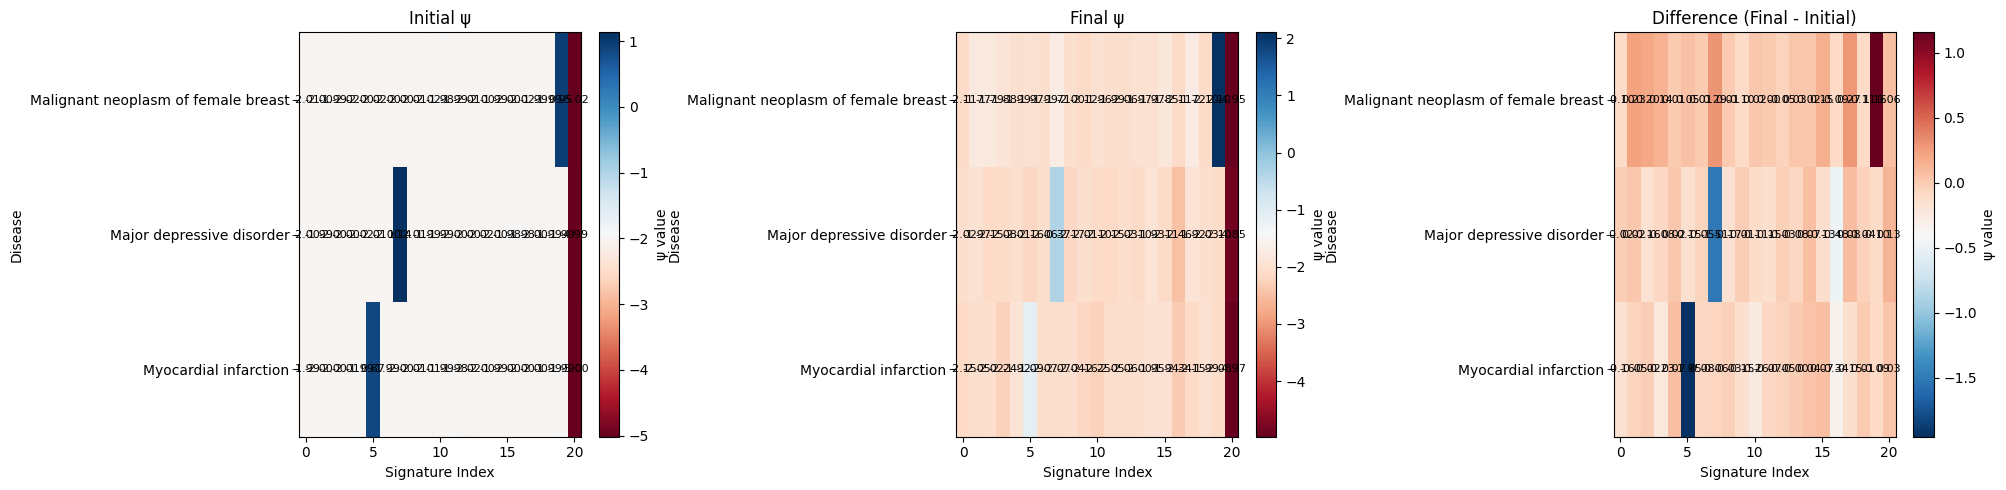

In [80]:
def visualize_psi_evolution_compact(model, checkpoint, condition_indices):
    """
    Create three heatmaps (initial, final, difference) showing all diseases together
    """
    # Get initial and final psi
    initial_psi = checkpoint['initial_state']['psi']
    final_psi = model.psi
    
    # Create figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    titles = ['Initial ψ', 'Final ψ', 'Difference (Final - Initial)']
    
    # Prepare data for each subplot
    data = []
    for condition_idx in condition_indices:
        initial = initial_psi[:, condition_idx].detach().numpy()
        final = final_psi[:, condition_idx].detach().numpy()
        difference = final - initial
        data.append([initial, final, difference])
    
    # Convert to numpy arrays
    data = np.array(data)  # Shape: (n_diseases, 3, n_signatures)
    
    # Plot each heatmap
    for i, (ax, title) in enumerate(zip(axes, titles)):
        im = ax.imshow(data[:, i, :], aspect='auto', 
                      cmap='RdBu_r' if 'Difference' in title else 'RdBu')
        plt.colorbar(im, ax=ax, label='ψ value')
        
        # Customize plot
        ax.set_xlabel('Signature Index')
        ax.set_ylabel('Disease')
        ax.set_title(title)
        
        # Set disease names as y-tick labels
        ax.set_yticks(range(len(condition_indices)))
        ax.set_yticklabels([model.disease_names[idx] for idx in condition_indices])
        
        # Add value annotations
        for y in range(data.shape[0]):
            for x in range(data.shape[2]):
                ax.text(x, y, f'{data[y, i, x]:.2f}', 
                       ha='center', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Usage:
conditions = [17, 66, 112]  # Breast Cancer, Major Depression, MI
visualize_psi_evolution_compact(model, checkpoint, conditions)